## Summary

The task is to use deep learning technology to complete segmentation on brain MRI (magnetic resonance) images, that is, for a processed MRI image, the lesion area will be segmented out.  

The data set used in this case is the "Brain MRI Images for Brain Tumor Detection" from Kaggl]. It contains MRI data of 110 patients. Each patient corresponds to multiple images(in .tif format) with a channel number of 3, and the corresponding segmentation result is a single-channel black and white image (white represents the diseased area)  
.
The U-N2] network is provided within the code framework. We tested how it behaves with different loss functions and optimizers. We also look into U-Net++ and TransU-Net structures. Due to the time scope limitation, we have to focus only on U-Net structure. With the same optimizer and the same loss function, U-Net++ has a slightly better performance(0.2%-0.3% higher DSC scores), but not statistically significant. The best DSC score with U-Net is 0.915472, and the best with U-Net++ is , both with Dice loss and Adam optimizer  
. 
Both the U-Net and U-Net++ architectures have comparatively good performances on segmentation and edge maintenance, but still fail to detect accurate shapes especially when the target area is small or when the shape has edges with many turns. To improve this, we could test TransU-Net, or try to combine with some adaptive methods to detect these poor-behaving areas and make them tokens with higher importance or semantic meaning.
ng.


In [1]:
import os

from types import SimpleNamespace
import tqdm
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from medpy.filter.binary import largest_connected_component
from skimage.io import imsave
from torch.utils.data import DataLoader

from dataset import BrainSegmentationDataset as Dataset
from unet import UNet
from nestedunet import NestedUNet
from utils import dsc, gray2rgb, outline

C:\Users\ext.yiwen\anaconda3\envs\test\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Use the Trained Model to Perform Inference on the Validation Set

The model is trained in the train.py file under the same path.   

The configuration args down below specifies where the associated data output should be restored. For improving learning speed, both train and inference processes are on GPU.  

The learning results are measured by dice coefficient. 

### 1.1 Input Parameters
 
device: device No.  
batch_size: batch size 
weights: path of the trained model parameters
images: path of the data set
image_size: image size(input size of the neaural network)   
predictions: where to store inference images   
figure: where to store the dice coeeficient diagrams after training and inference

In [2]:
args = SimpleNamespace(
    device = 'cuda:0',
    batch_size = 32,
    weights = './weights/nestedunet.pt',
    images = './kaggle_3m',
    image_size = 256,
    predictions = './predictions_unet',
    figure = './dsc_unet.png',
)

In [3]:
device = torch.device("cpu" if not torch.cuda.is_available() else args.device)

In [4]:
device

device(type='cuda', index=0)

### 1.2 Data Loader and Diagram Generation

In this section, we define the data loader to read the data set in. We also create functions to draw diagrams for dice coefficient of different volumes(expression profiles for tumor and normal tissue samples). 

In [41]:
# read data in
def data_loader(args):
    dataset = Dataset(
        images_dir=args.images,
        subset="validation",
        image_size=args.image_size,
        random_sampling=False,
    )
    loader = DataLoader(
        dataset, batch_size=args.batch_size, drop_last=False, num_workers=1
    )
    return loader

# preprocess data; below processing is run on the data read in:
# cropping, padding, resizing, normalizing
def postprocess_per_volume(
    input_list, pred_list, true_list, patient_slice_index, patients
):
    volumes = {}
    num_slices = np.bincount([p[0] for p in patient_slice_index])
    index = 0
    for p in range(len(num_slices)):
        volume_in = np.array(input_list[index : index + num_slices[p]])
        volume_pred = np.round(
            np.array(pred_list[index : index + num_slices[p]])
        ).astype(int)
        volume_pred = largest_connected_component(volume_pred)
        volume_true = np.array(true_list[index : index + num_slices[p]])
        volumes[patients[p]] = (volume_in, volume_pred, volume_true)
        index += num_slices[p]
    return volumes

# calculate statistical results on dice coefficient
def dsc_distribution(volumes):
    dsc_dict = {}
    for p in volumes:
        y_pred = volumes[p][1]
        y_true = volumes[p][2]
        dsc_dict[p] = dsc(y_pred, y_true, lcc=False)
    return dsc_dict

# draw diagram for dice coefficients for differnt tumor volumes
def plot_dsc(dsc_dist):
    y_positions = np.arange(len(dsc_dist))
    dsc_dist = sorted(dsc_dist.items(), key=lambda x: x[1])
    values = [x[1] for x in dsc_dist]
    labels = [x[0] for x in dsc_dist]
    labels = ["_".join(l.split("_")[1:-1]) for l in labels]
    fig = plt.figure(figsize=(12, 8))
    canvas = FigureCanvasAgg(fig)
    plt.barh(y_positions, values, align="center", color="skyblue")
    plt.yticks(y_positions, labels)
    plt.xticks(np.arange(0.0, 1.0, 0.1))
    plt.xlim([0.0, 1.0])
    plt.gca().axvline(np.mean(values), color="tomato", linewidth=2)
    plt.gca().axvline(np.median(values), color="forestgreen", linewidth=2)
    plt.xlabel("Dice coefficient", fontsize="x-large")
    plt.gca().xaxis.grid(color="silver", alpha=0.5, linestyle="--", linewidth=1)
    plt.tight_layout()
    canvas.draw()
    plt.close()
    s, (width, height) = canvas.print_to_buffer()
    return np.fromstring(s, np.uint8).reshape((height, width, 4))


### 1.3 Inference

This is where inference happens and diagrams are drawn based on the dice coefficients of volumes from learning.

In [63]:
os.makedirs(args.predictions, exist_ok=True)
device = torch.device("cpu" if not torch.cuda.is_available() else args.device)

loader = data_loader(args)

with torch.set_grad_enabled(False):
    nested_unet = NestedUNet(in_channels=Dataset.in_channels, out_channels=Dataset.out_channels)
    state_dict = torch.load(args.weights, map_location=device)
    nested_unet.load_state_dict(state_dict)
    nested_unet.eval()
    nested_unet.to(device)

    input_list = []
    pred_list = []
    true_list = []

    for i, data in enumerate(tqdm.tqdm(loader)):
        x, y_true = data
        x, y_true = x.to(device), y_true.to(device)

        y_pred = nested_unet(x)
        y_pred_np = y_pred.detach().cpu().numpy()
        pred_list.extend([y_pred_np[s] for s in range(y_pred_np.shape[0])])

        y_true_np = y_true.detach().cpu().numpy()
        true_list.extend([y_true_np[s] for s in range(y_true_np.shape[0])])

        x_np = x.detach().cpu().numpy()
        input_list.extend([x_np[s] for s in range(x_np.shape[0])])

volumes = postprocess_per_volume(
    input_list,
    pred_list,
    true_list,
    loader.dataset.patient_slice_index,
    loader.dataset.patients,
)

dsc_dist = dsc_distribution(volumes)

dsc_dist_plot = plot_dsc(dsc_dist)
imsave(args.figure, dsc_dist_plot)


reading validation images...
preprocessing validation volumes...
cropping validation volumes...
padding validation volumes...
resizing validation volumes...
normalizing validation volumes...
done creating validation dataset


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.59it/s]
C:\Users\ext.yiwen\AppData\Local\Temp\ipykernel_20536\4176651710.py:63: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(s, np.uint8).reshape((height, width, 4))


In [64]:
for p in tqdm.tqdm(volumes):
    x = volumes[p][0]
    y_pred = volumes[p][1]
    y_true = volumes[p][2]
    for s in range(x.shape[0]):
        image = gray2rgb(x[s, 1])  # channel 1 is for FLAIR
        image = outline(image, y_pred[s, 0], color=[255, 0, 0]) # red -> hat
        image = outline(image, y_true[s, 0], color=[0, 255, 0]) # green -> groundtruth
        filename = "{}-{}.png".format(p, str(s).zfill(2))
        filepath = os.path.join(args.predictions, filename)
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        imsave(filepath, image)


 40%|█████████████████████████████████▏                                                 | 4/10 [00:03<00:04,  1.20it/s]C:\Users\ext.yiwen\AppData\Local\Temp\ipykernel_20536\820498016.py:12: UserWarning: ./predictions_sa_sgd\kaggle_3m\TCGA_DU_7014_19860618-57.png is a low contrast image
  imsave(filepath, image)
 50%|█████████████████████████████████████████▌                                         | 5/10 [00:05<00:06,  1.39s/it]C:\Users\ext.yiwen\AppData\Local\Temp\ipykernel_20536\820498016.py:12: UserWarning: ./predictions_sa_sgd\kaggle_3m\TCGA_DU_6408_19860521-51.png is a low contrast image
  imsave(filepath, image)
C:\Users\ext.yiwen\AppData\Local\Temp\ipykernel_20536\820498016.py:12: UserWarning: ./predictions_sa_sgd\kaggle_3m\TCGA_DU_6408_19860521-52.png is a low contrast image
  imsave(filepath, image)
C:\Users\ext.yiwen\AppData\Local\Temp\ipykernel_20536\820498016.py:12: UserWarning: ./predictions_sa_sgd\kaggle_3m\TCGA_DU_6408_19860521-53.png is a low contrast image
  imsave(fil

## 2. Compare and Contrast on U-Net with Different Loss Functions and Optimizers

### 2.1 Background Research 

---
### U-Net

ref: https://en.wikipedia.org/wiki/U-Net#:~:text=U%2DNet%20is%20a%20convolutional,of%20the%20University%20of%20Freiburg.  
ref: https://arxiv.org/pdf/1505.04597v1.pdf  

U-Net is a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg. The network is based on a fully convolutional neural network, whose architecture was modified and extended to work with fewer training images and to yield more precise segmentation.   

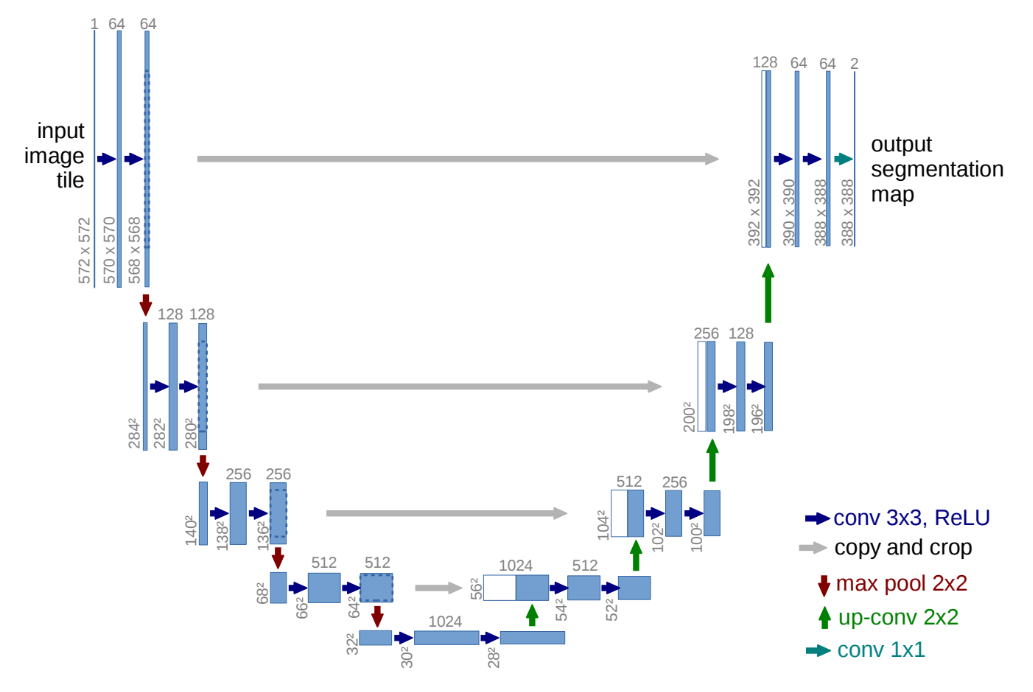


---
### Data Argumentation

ref: https://en.wikipedia.org/wiki/Data_augmentation  
Data augmentation is a technique in machine learning used to reduce overfitting when training a machine learning model, by training models on several slightly-modified copies of existing data.  

ref: https://arxiv.org/pdf/2006.14822v4.pdf  
All the technological advancements in the field of Artificial Intelligence (AI) is facilitated due to the availability large amount of dataset and the computational hardware’s like GPU’s and TPU’s. In some fields like medical imaging, the availability of the huge amount of data is not possible, as it takes a good amount of efforts to collect the data and then labelling it requires the domain expertise. To, solve this issue, we use data augmentation. In short, data argumention in image segmentation allows us to increase the amount of training data by making some reasonable modifications or transformations in the existing data.    

In our framework, data read-in and data argumentation happens in transform.py and dataset.py. The argumentation preprocessing contains: cropping, padding, resizing and normalization. Except these common-used traditional argumentation methods, some other argumentation ways are listed in the image below.  

ref: https://www.mdpi.com/2313-433X/9/2/46
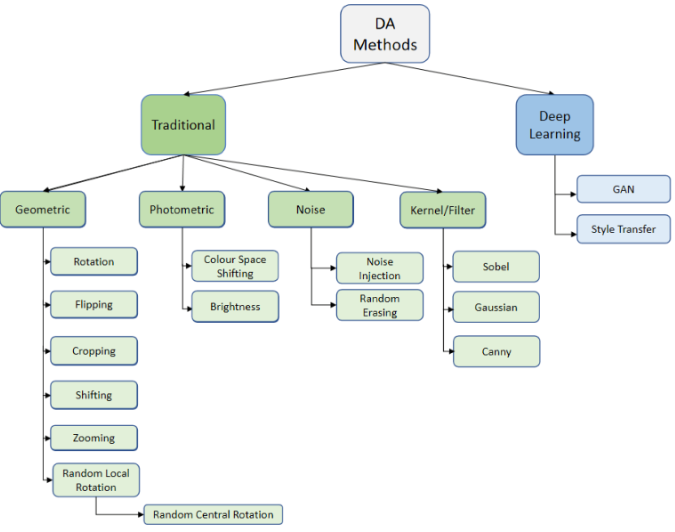  


---
### Loss Functions for Segmentation 

ref: https://dev.to/_aadidev/3-common-loss-functions-for-image-segmentation-545o  

The choice of loss function for the task of segmentation is key in determining both the speed at which a Machine-Learning model converges, as well to some extent, the accuracy of the model.  
There are three common loss functions for image segmentation tasks: Dice Coefficient Loss, Binary Cross-Entropy Loss, Shape-Aware Loss. Apart from these three, Hausdorff Distance Loss also has its advantage at maintaining more precise edges of segmented shapes. However, due to its non-convex nature, it is not widely used as loss function.  

ref: https://arxiv.org/pdf/2006.14822.pdf#:~:text=Log%2DCosh%20Dice%20Loss(ours)%20Variant%20of%20Dice%20Loss,metric%20by%20adding%20some%20variations  
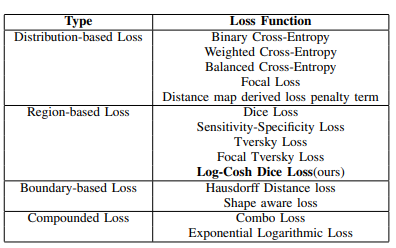

In the paper referenced above, they also proposed a Log-Cosh Dice Loss, a variant of Dice Loss and inspired regression log-cosh approach for smoothing variations.  

#### Dice Loss
ref: https://medium.com/@lathashreeh/dice-coefficient-what-is-it-ff090ec97bda  

Dice coefficient is a similarity metric commonly used in image segmentation, natural language processing, and other fields where there is a need to measure the similarity between two sets. Also called the “Sørensen–Dice coefficient”, it was first introduced by Lee R. Dice in 1945 and Thorvald Sørensen in 1948 and has ever since become a widely used metric due to its simplicity and effectiveness.

It is particularly useful for imbalanced datasets, where one set may be much larger than the other. It is a better choice for image segmentation tasks, as it is more sensitive to overlap between the predicted and ground truth masks.

A high Dice coefficient value indicates a high level of similarity between the predicted and ground truth masks, meaning that the segmentation model or algorithm is performing well.  

#### Log-Cosh Dice Loss  
ref: https://arxiv.org/pdf/2006.14822.pdf#:~:text=Log%2DCosh%20Dice%20Loss(ours)%20Variant%20of%20Dice%20Loss,metric%20by%20adding%20some%20variations    
Variant of Dice Loss and inspired regression log-cosh approach for smoothing.
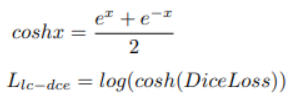


#### Binary Cross-Entropy Loss  
ref: https://medium.com/dejunhuang/learning-day-57-practical-5-loss-function-crossentropyloss-vs-bceloss-in-pytorch-softmax-vs-bd866c8a0d23  
CrossEntropyLoss is mainly used for multi-class classification, binary classification is doable; And BCE is for binary classification. A major difference is that if you want to generate output as a form of probability, you should use BCE. That’s because we can use sigmoid to process the single output while using BCELoss as the loss function.
For CrossEntropyLoss, softmax is a more suitable method for getting probability output. However, for binary classification when there are only 2 values, the output from softmax is always going to be something like [0.1%, 99.9%] or [99.9%, 0.1%] based on its formula. Eg. softmax([-2,34, 3,45])=[0.3%, 99.7%]. It does not represent meaningful probability.  

ref: https://towardsdatascience.com/dealing-with-class-imbalanced-image-datasets-1cbd17de76b5#:~:text=Unlike%20BCE%2C%20dice%20coefficient%20only,predicted%20mask%20and%20the%20groundtruth.   
Unlike BCE, dice coefficient only considers the segmentation class and not the background class. The pixels are classified as True Positive (TP), False Negative (FN) and False Positive (FP). The dice coefficient is a measure of overlap of the predicted mask and the groundtruth.

#### Shape-Aware Loss   
Shape-aware loss as the name suggests takes shape into
account. Generally, all loss functions work at pixel level, however, Shape-aware loss calculates the average point to curve
Euclidean distance among points around curve of predicted
segmentation to the ground truth and use it as coefficient to
cross-entropy loss function. 

## 3. U-Net with Adam Optimizer

In this section, we compare how U-Net performs with different losses under Adam optimizer.  
To cut down training budget and the report length, we only show the hyperparameter combinations that shout out comparatively good learning results under the same loss method. Therefore, many parameter tuning experiments are omitted.

### 3.1 U-Net with Adam Optimizer and Dice Loss
Configuration: 
`batch size: 16, max epochs: 100, learning rate: 0.0001, image size: 256, aug scale: 0.05, aug angle: 15`  

Time Elapse(Training): 4h8m -- 2.48min/epoch 

Prediction image: ./Prediction/Kaggle_3m  
Logs: ./logs  

Best validation mean DSC: 0.915472    

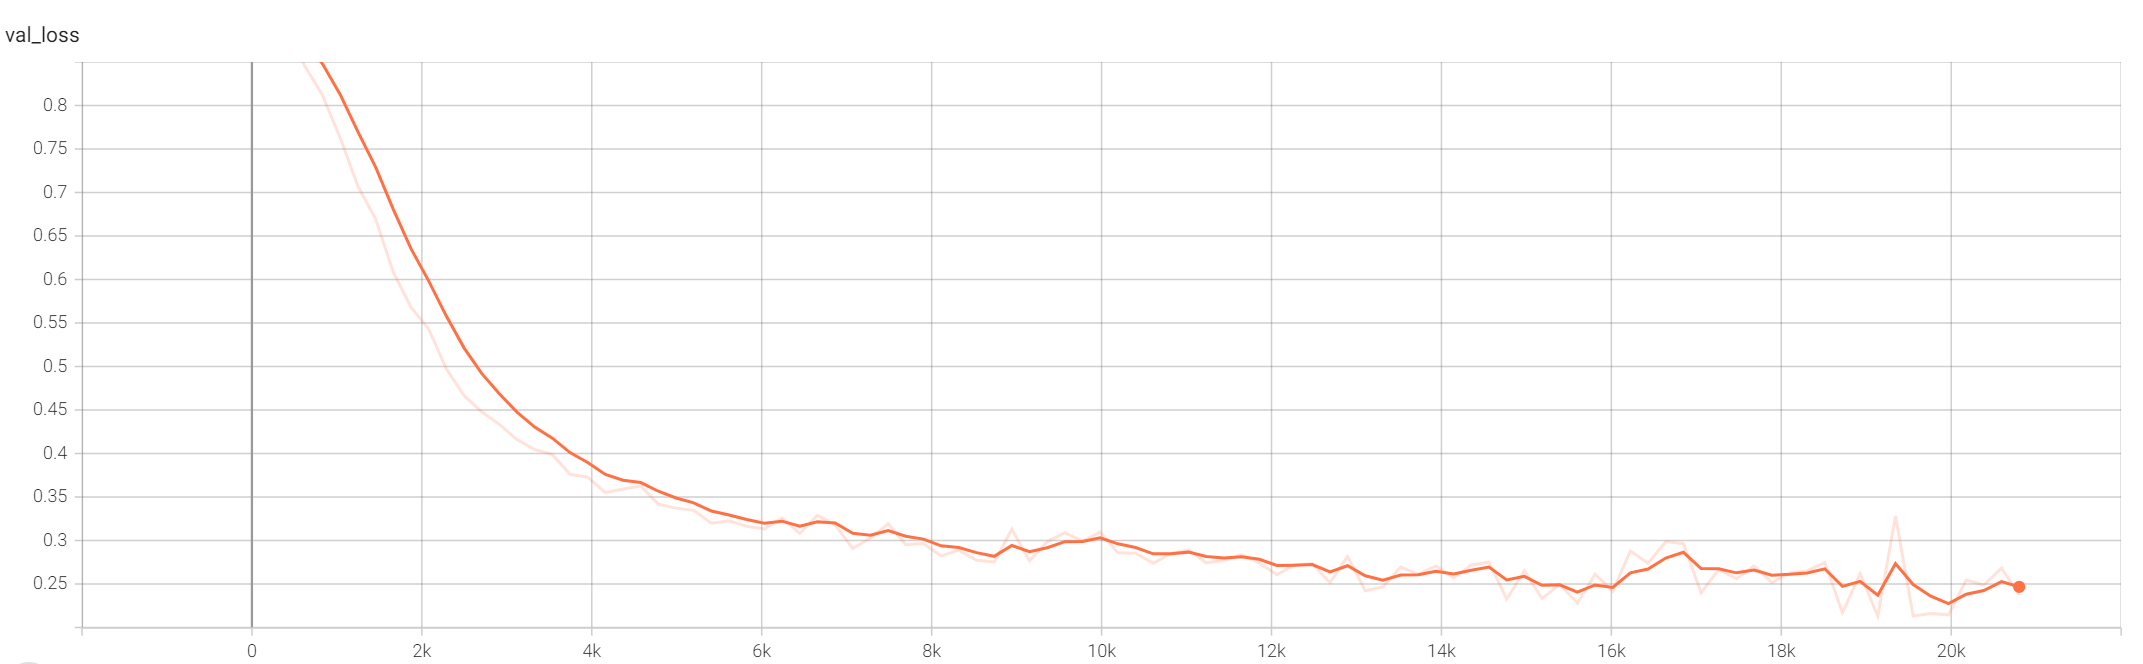
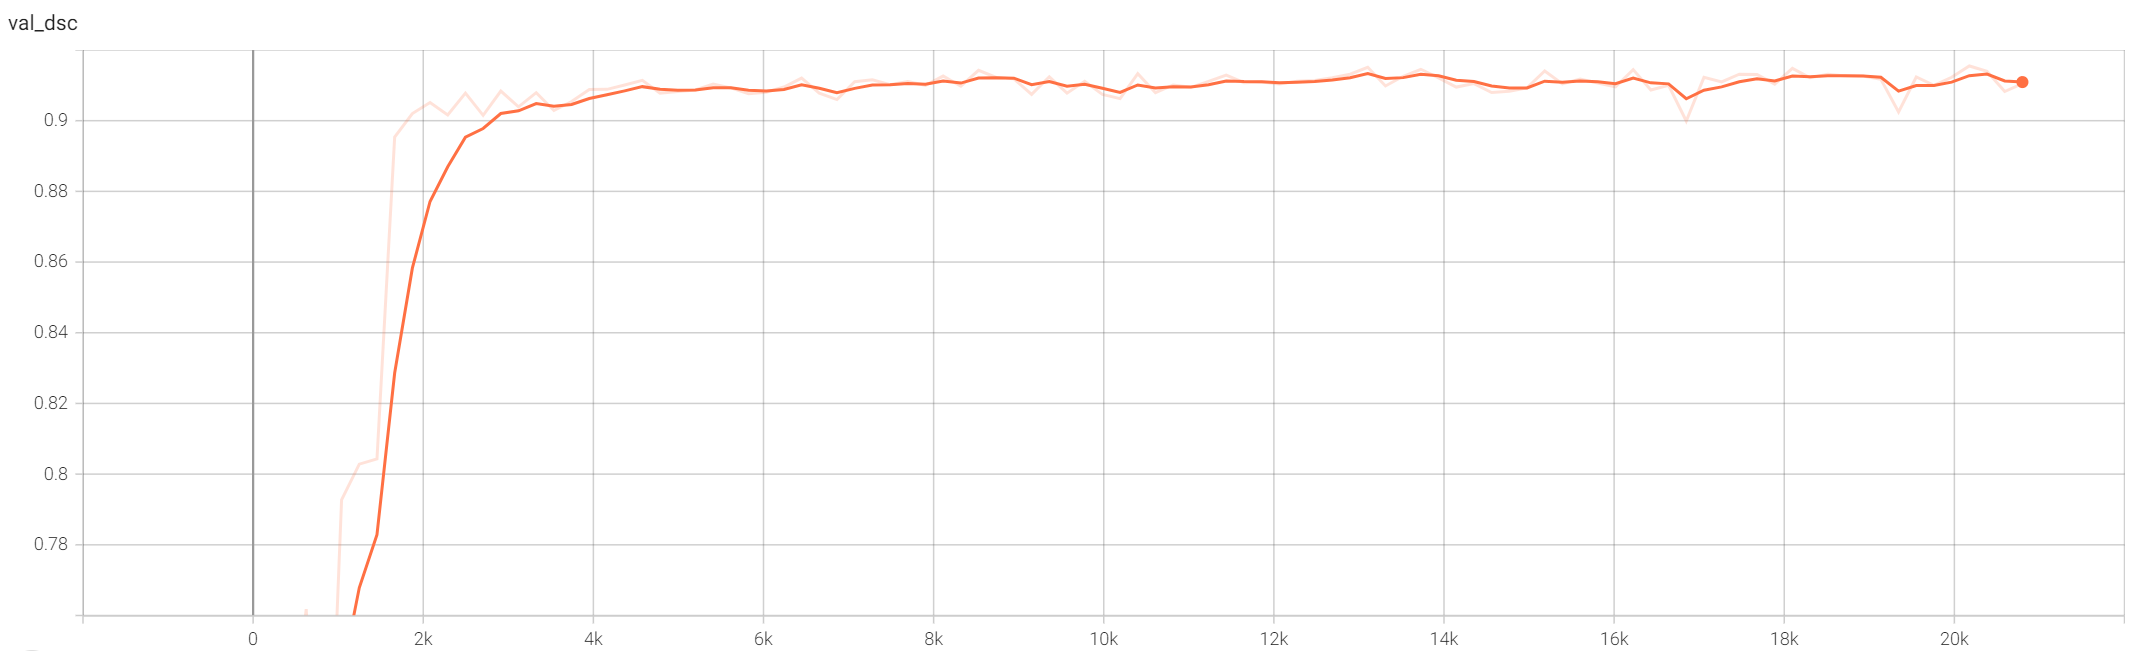
---

### 3.2 U-Net with Adam Optimizer and Binary Cross Entropy Loss
Configuration: 
`batch size: 16, max epochs: 40, learning rate: 0.0001, image size: 256, aug scale: 0.05, aug angle: 15`  

Time Elapse(Training): 1h22m -- 2.05min/epoch 

Prediction image: ./Prediction_02/Kaggle_3m  
Logs: ./logs_02  

Best validation mean DSC: 0.914088     

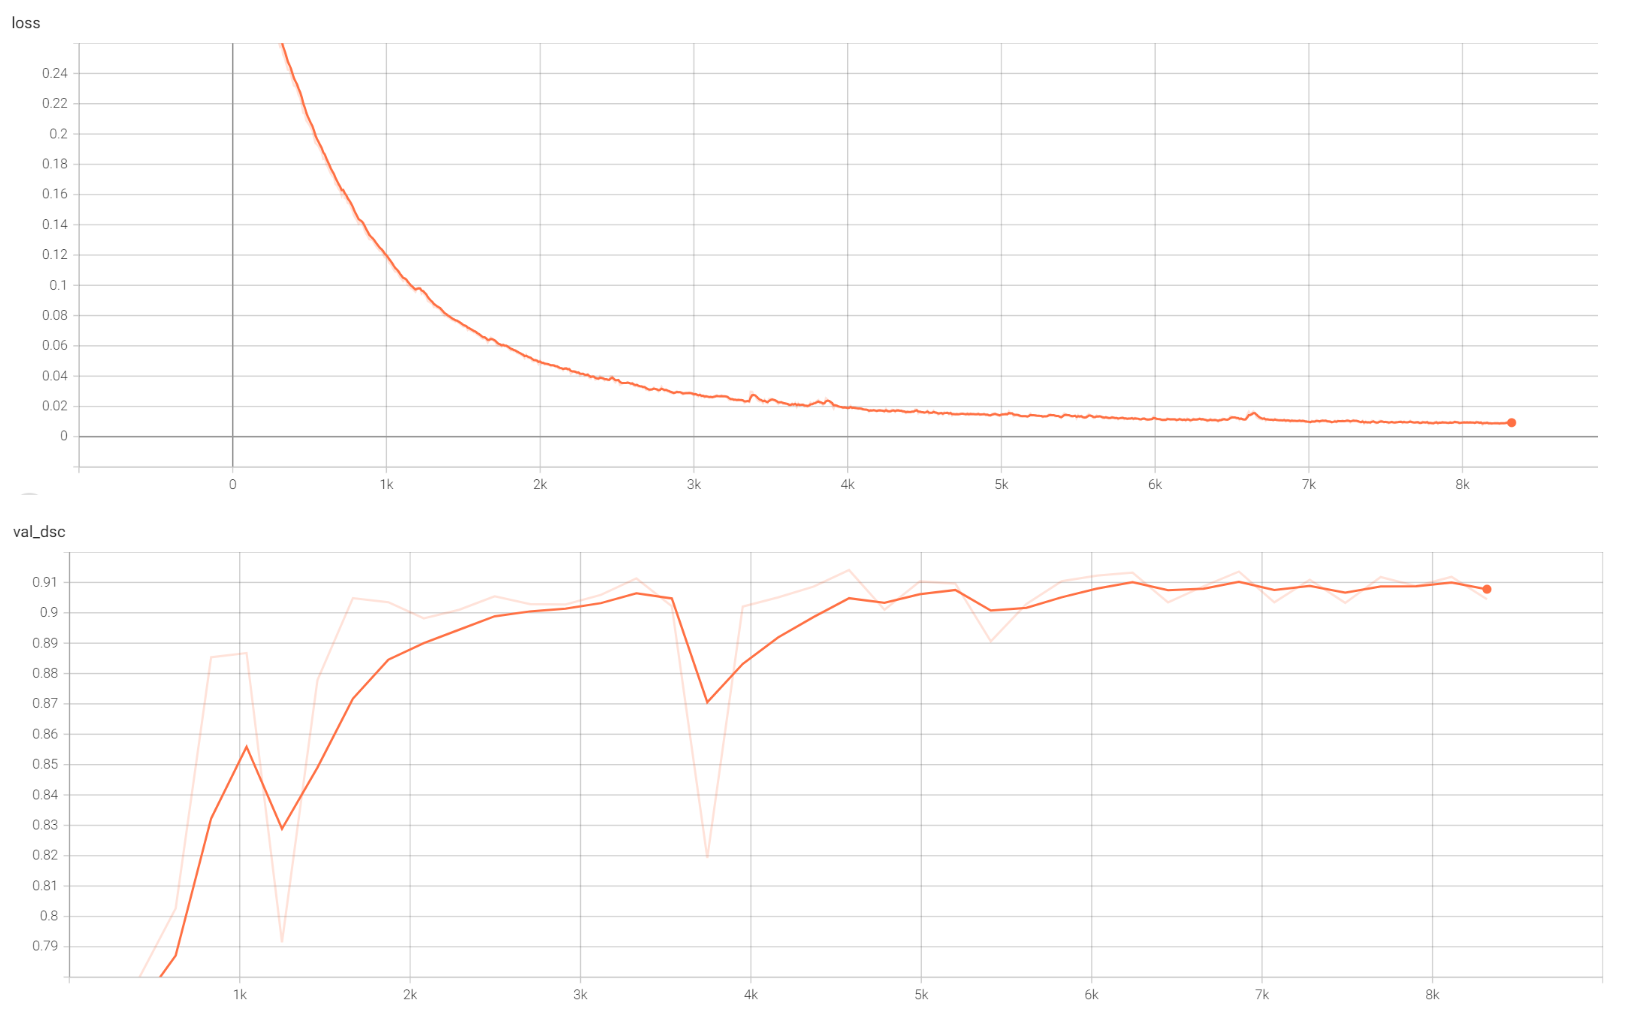

---

### 3.3 U-Net with Adam Optimizer and Log Cosh Dice Loss
Configuration: 
`batch size: 20, max epochs: 25, learning rate: 0.0001, image size: 256, aug scale: 0.05, aug angle: 15`  

Time Elapse(Training): 52m -- 2.08min/epoch 

Prediction image: ./Prediction_03/Kaggle_3m  
Logs: ./logs_03  

Best validation mean DSC: 0.911516   

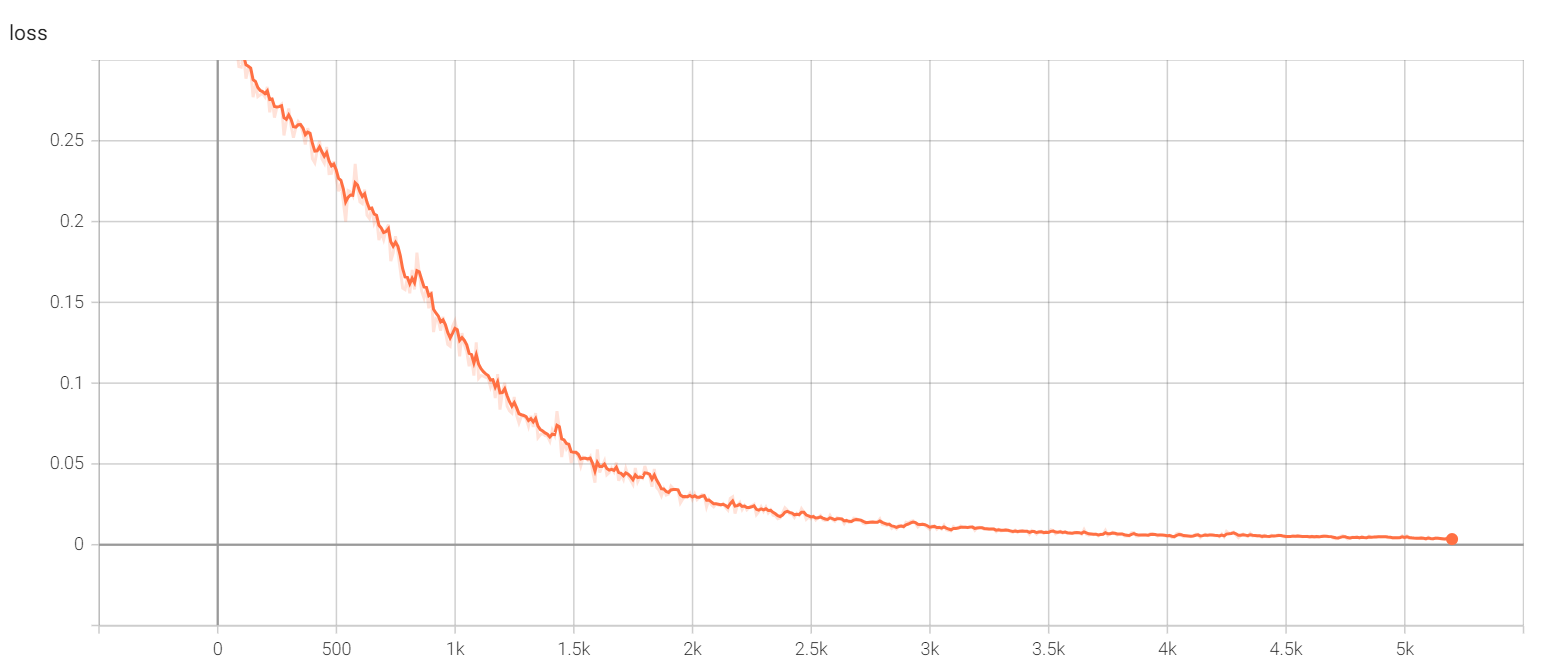
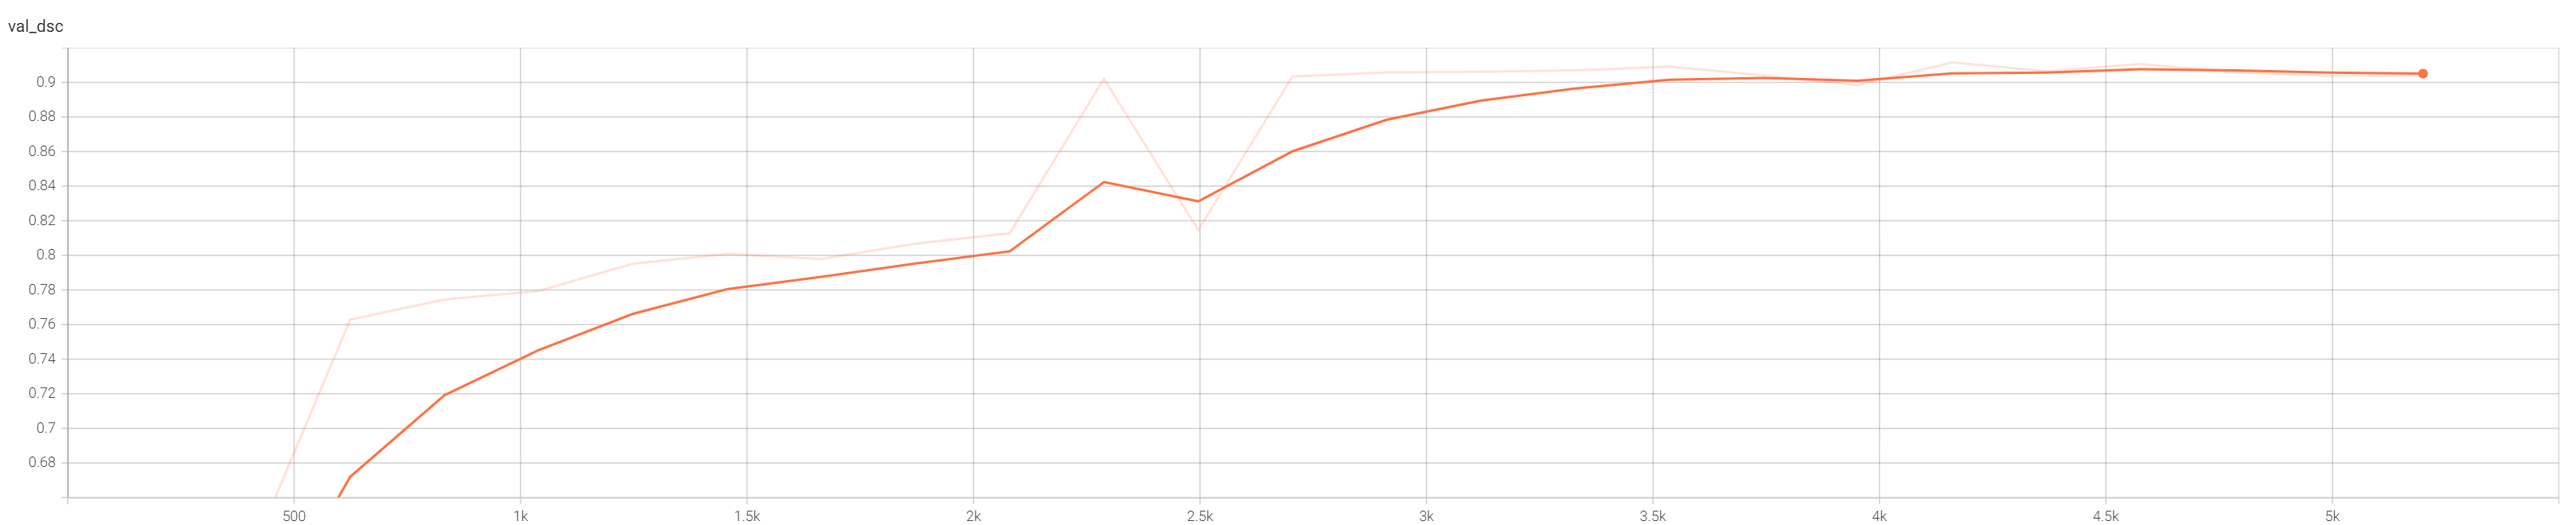  

---

### 3.4 U-Net with Adam Optimizer and Shape-Aware Loss
Configuration: 
`batch size: 20, max epochs: 50, learning rate: 0.0001, image size: 256, aug scale: 0.05, aug angle: 15`  

Time Elapse(Training): 1h39min -- 1.98min/epoch 

Prediction image: ./Prediction_06/Kaggle_3m  
Logs: ./logs_06  

Best validation mean DSC: 0.914978   

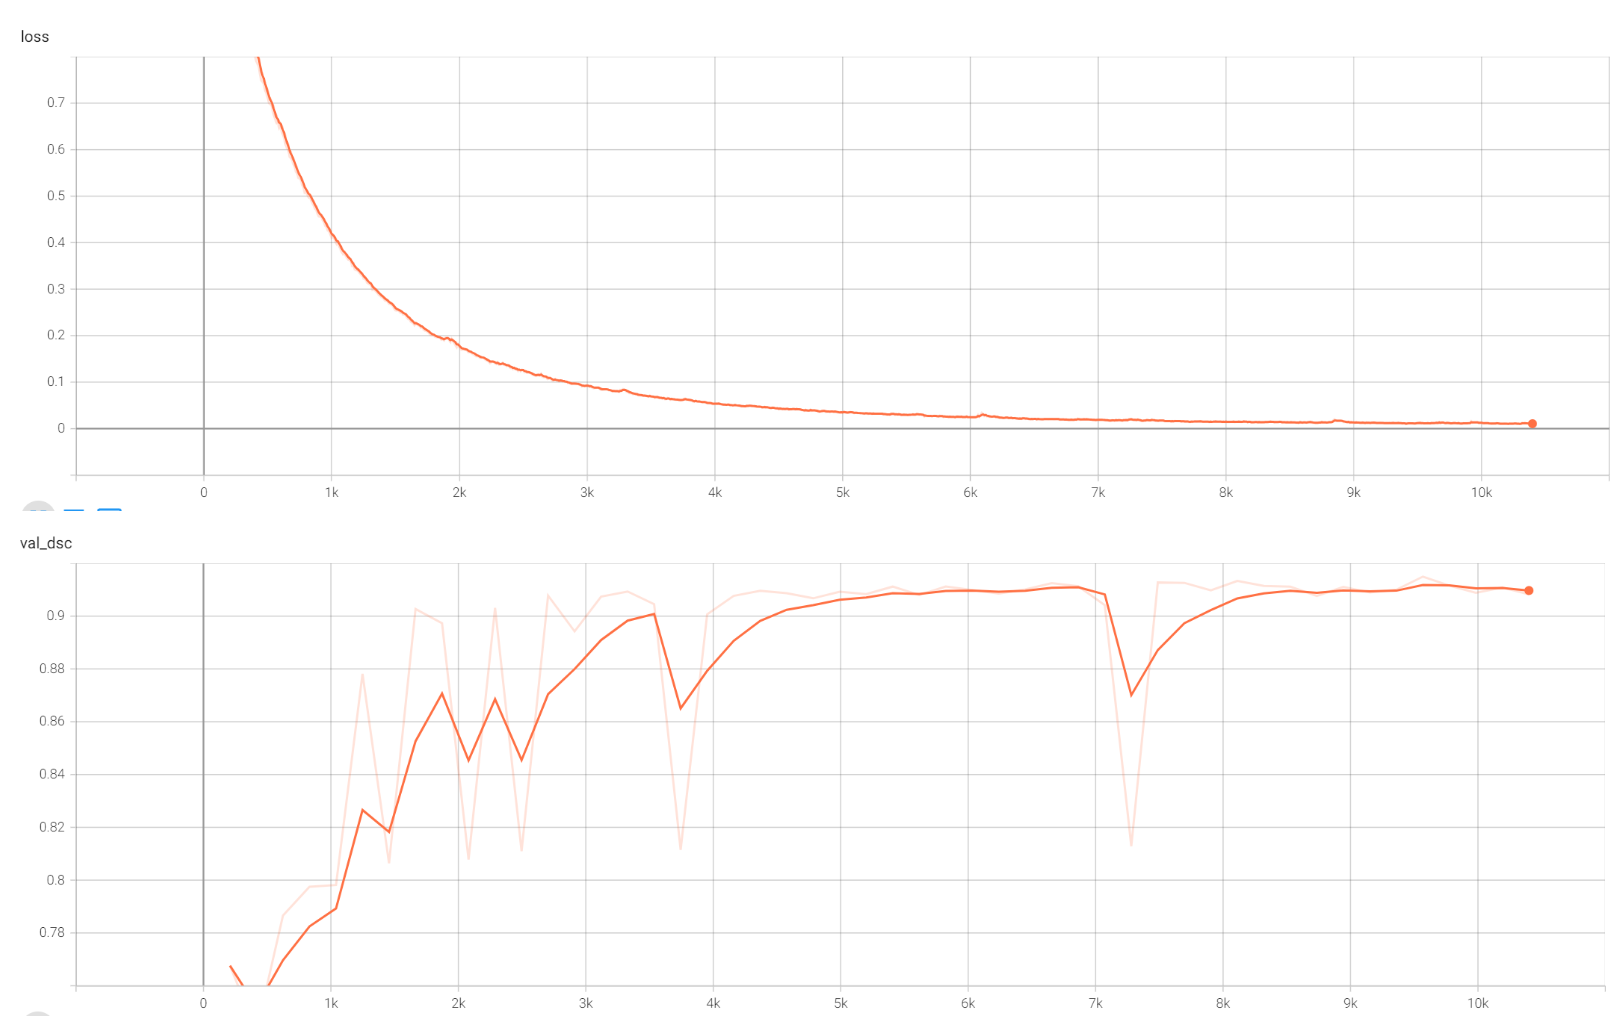

---
### Compare and Contrast
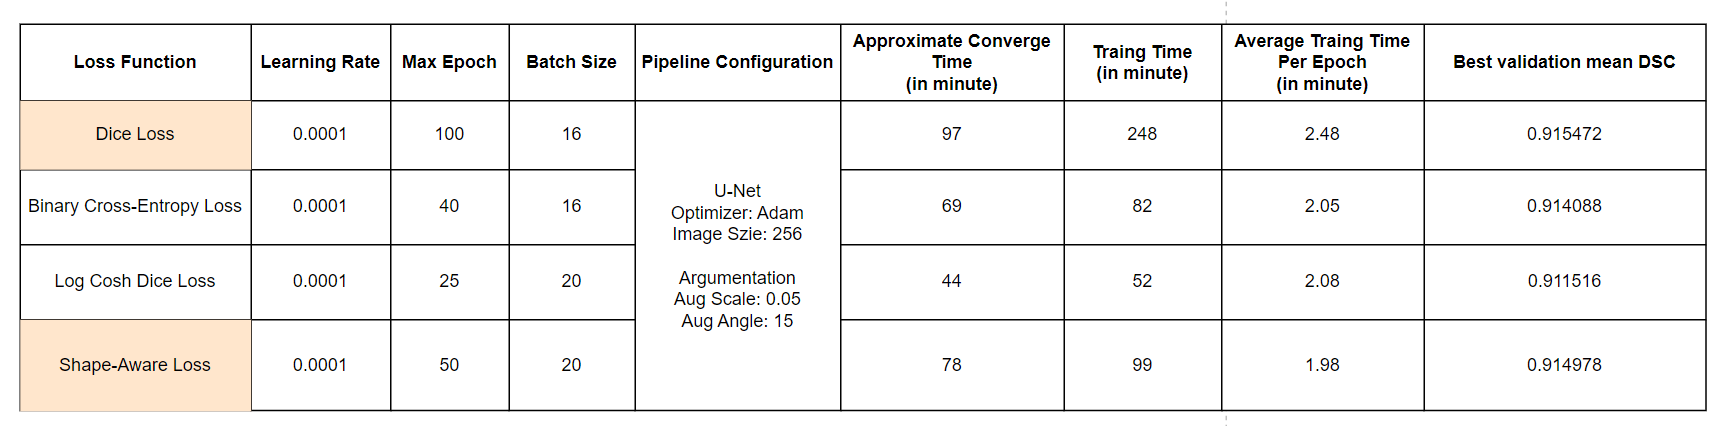  

### Inference Dice Coefficient
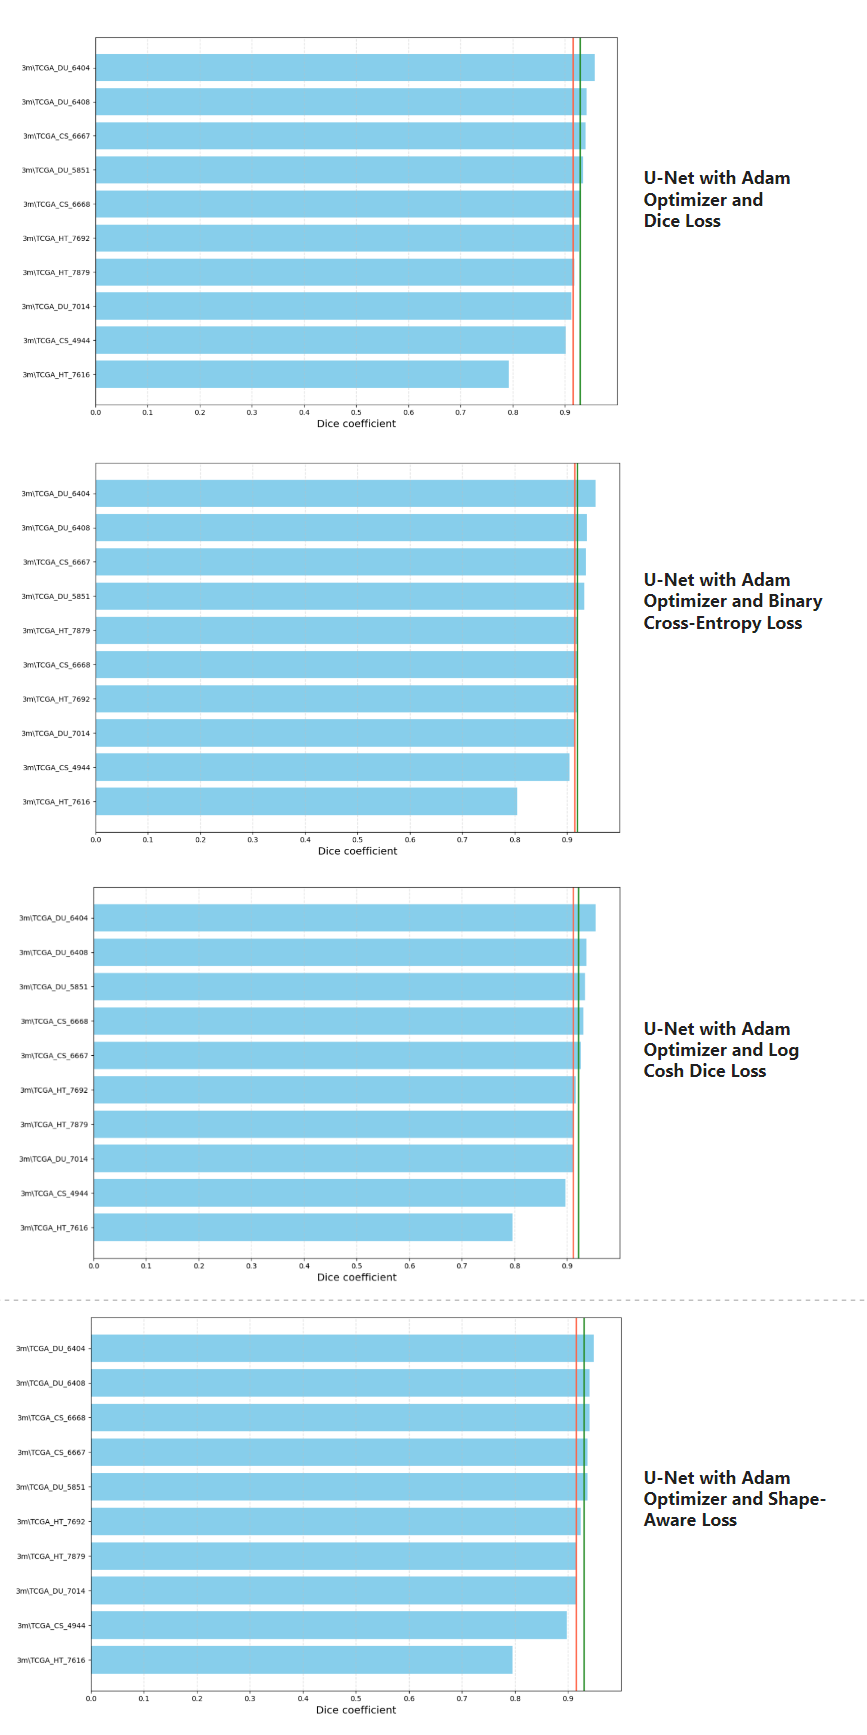

---
### Segmentation Examples
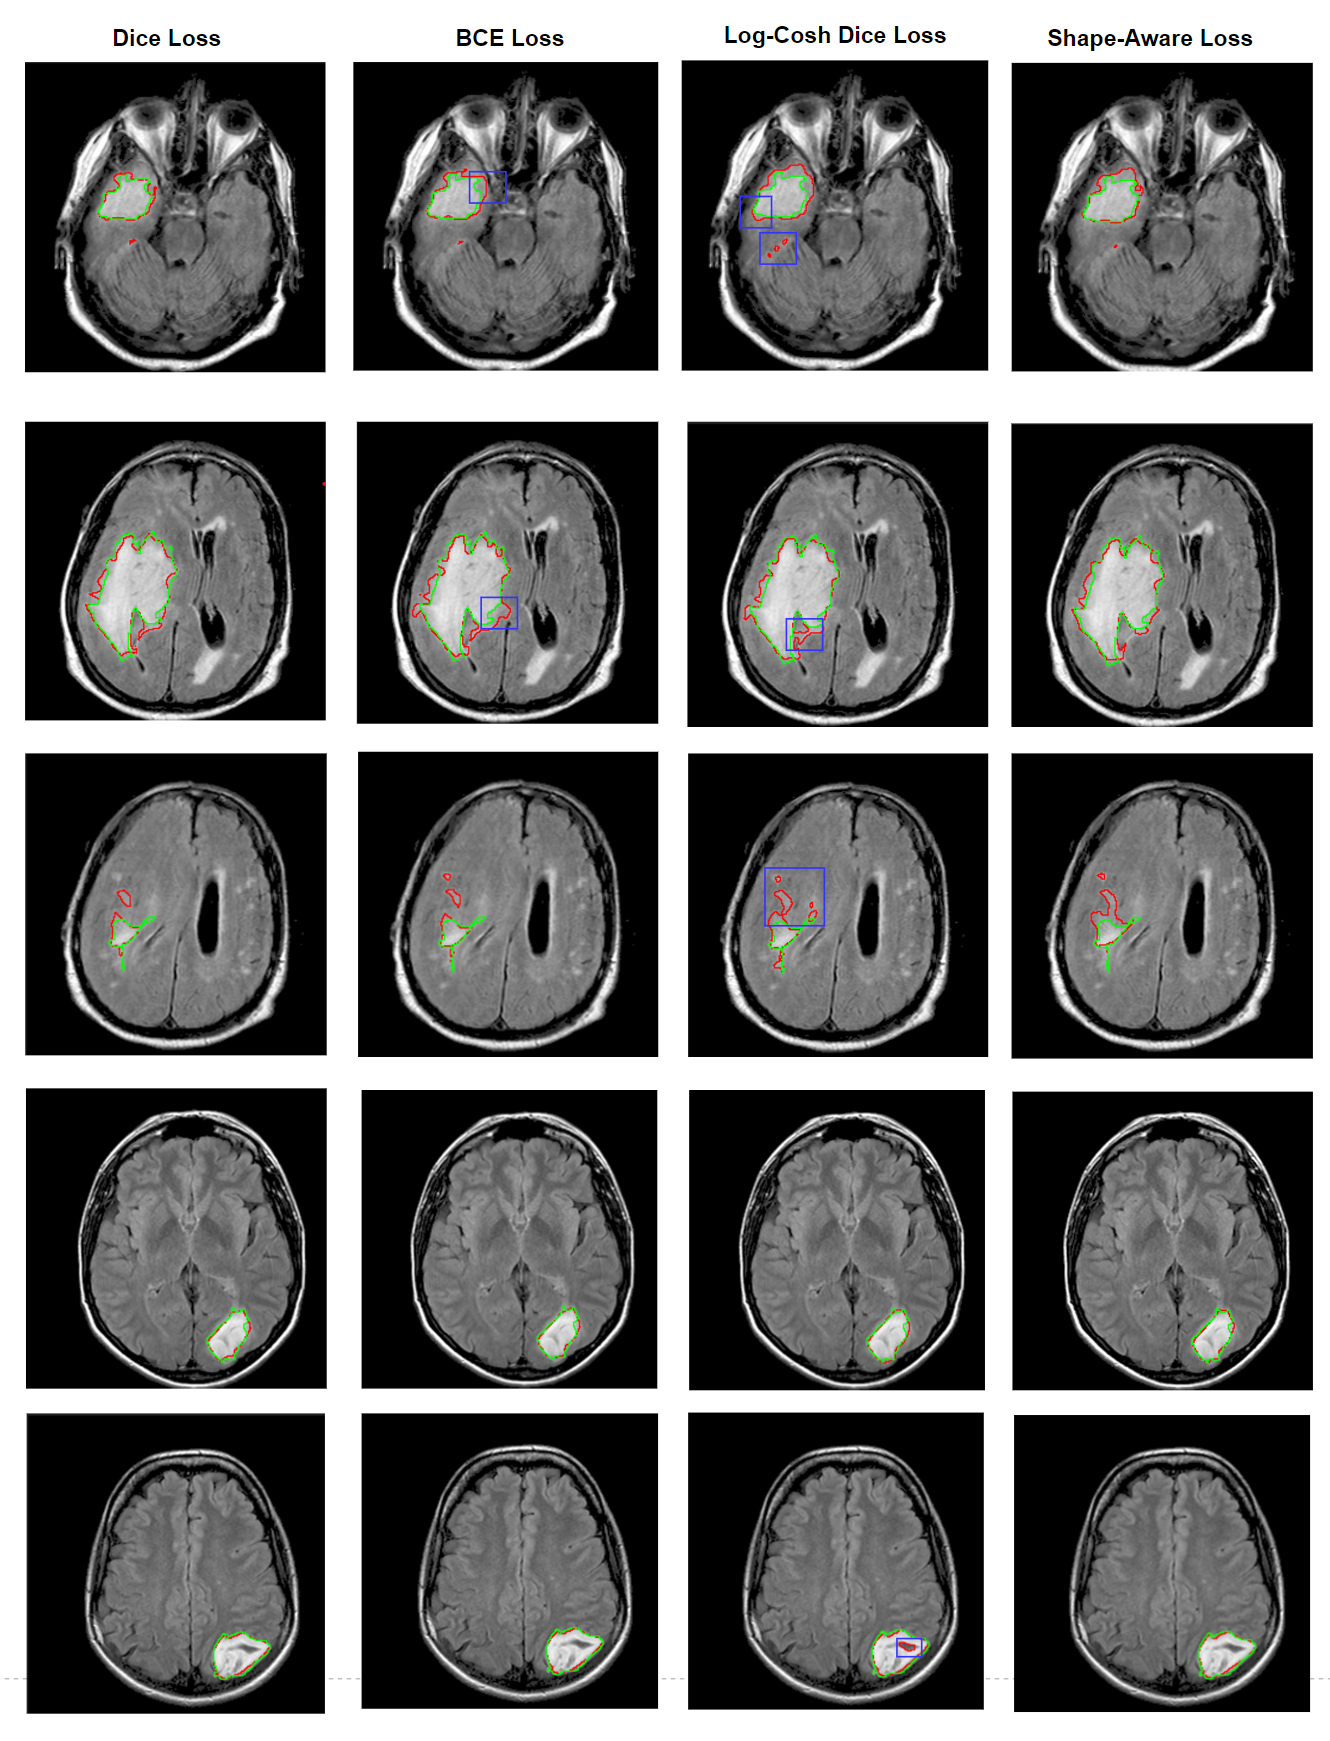 

---
### Analysis
1. With U-Net architecture and Adam optimizer, our model has the best performances(mean DSC on validation set) with  
Dice Loss and Shape-Aware Loss  Dice loss is generally useful for region-based classification, and Shape-Aware loss works better
with boundary-based classification.
2. Binary Cross-Entropy(refer as BCE in the report) and Log-Cosh Dice loss have comparatively mediocre performances. BCE usualy 
works better  ith equal data-distribution amongst classes. That is, image masks with very heavy class inbalnce
(such as in finding very small, rare tumors from X-ray images) may not be  adequately evaluated by   BCE. 
ref: https://dev.to/_aadidev/3-common-loss-functions-for-image-segmentation-545o#:~:text=Binary%20Cross%2DEntropy,-Cross%2Dentropy%20is&text=It%20is%20more%20generally%20based,be%20adequately%20evaluated%20by%20BCE. 
3. Based on the analysis in <2>, to improve model behaviours with cross-entropy related loss, we should introduce in Weghted 
Cross-Entropy or Balanced Cross-Entropy, since they are widely used with unbanlanced data distribution. Focal loss also seem to be 
a good direction to investigate into. 
4. Log-Cosh Dice loss has the worst performances here. However, theoretically, it should provide good learning results as it cn smooth 
variants for skewed dataset. Also, see from its loss diagram, the loss curve drops slowly at the first 1/6 epochs and thn follows 
a common elbow shape  This means that our hyperparameter setting is not suitable. Perhaps the learning rate is too smal that the 
network has to spend comparatively long  ime to reach a point that could actually learning the classification rules. If tme applies, 
we will try tune parameters for this network. 
5. With BSE, Log-Cosh Dice and Shape-Aware loss, all validation DSC curves fluctuates a lot along the traing process. Among wh ch Shape Aware
loss has the dsc curve with the most fluctuations. However, its loss curve is quite smooth. DSC is based on hard classifcation; if the 
probability scores are hovering near the threshold, then the classifications may be flopping a lot, leading to uns able DSC scores.
ref: https://datascience.stackexchange.com/questions/41340/issue-with-early-stopping-on-f1-score-wi   th-imbalanced-data
We should also introduce IoU score(Jaccard index) to observe thearea of the intersection over union of the predicted segmentation and the ground truth.
However, choosing dice coefficient over IoU or vice versa is based on specific us  e cases of the task.
ref: https://medium.com/mlearning-ai/understanding-evaluation-metrics-in-medical-image-segmentation-d289a373a3f
6. The green vertical line in the dice coefficient diagram shows the median of dice coefficients of all volume (tumor types/labels).
The red one specifies the mean value of dice coefficients of all volumes. Mean is more often closer to the true center o  describing a bunch of
values than the median. The median can sometime be inaccurate because it does not use very much of the information avai lable in the data. 
ref:https://faculty.washington.edu/swithers/seestats/SeeingStatisticsFiles/seeing/center/meanvmedian3.html#:~:text=While%20the%20mean%20is%20the,less%20accu  rate%20than%20the%20mean.
But under skewed data, the median is more useful because the mean will   be distorted by outliers.
ref: https://towardsdatascience.com/mean-or-median-choose-based-on-the-decision-not-the-  distribution-f951215c1376  
7. As mentioned in <6>, since our data set is unbalanced, we will focus more on the median values of dice similarity coeffi ient, rather than the mean.
For all four diagrams, mean and median are close. This suggests that there are no extreme observations. The gap inbetween for D ce loss and Shape-Aware loss
is slightly larger, and the median under these two loss functions are slightly highr than the other two losses. 
A high Dice coefficient value indicates a high level of similarity between the predicted and ground truth masks, meanig that the segmentation model 
 or algorithm is performing well.
ref: https://medium.com/@lathashreeh/dice-coefficient-what-is-it-ff090ec97bda#:~:text=A%20high%20Dice%20coefficient%20value,value%20indicates%20p  oor%20segmentation%20performance.
8. In the "Segmentation Examples" section, green is the edge of the ground truth, red is the prediction edge, and blue circles that the ar as with 
clear poor segmentation.
We can see that Dice loss and Shape-Aware loss are better at detecting irregular shapes and maintaining borders with turns. and maintaining borders with turns. 

## 4. U-Net with SGD Optimizer

### 4.1 U-Net with Nestrove SGD Optimizer and Dice Loss
Configuration: `Batch Size: 20, Max Epoch: 100, Learning Rate: 0.001, Momentum: 0.9, Weight Decay: 1e-4, aug scale: 0.05, aug angle: 15`  

Time Elapse(Training): 3h55min -- 2.35min/epoch  converge around 3h7m      
Prediction image: ./predictions_dice_sgd  
Logs: ./logs_dice_sgd  

Best Validation Mean DSC: 0.812136

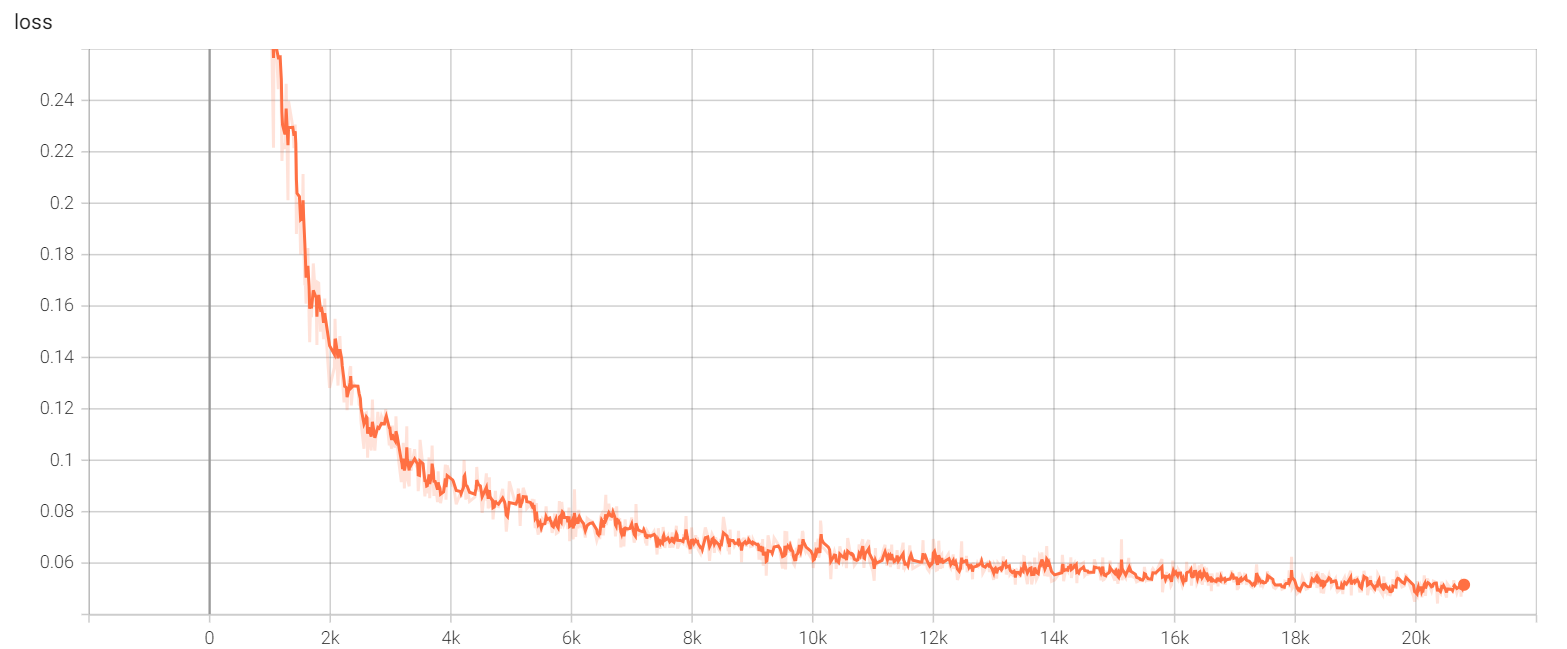
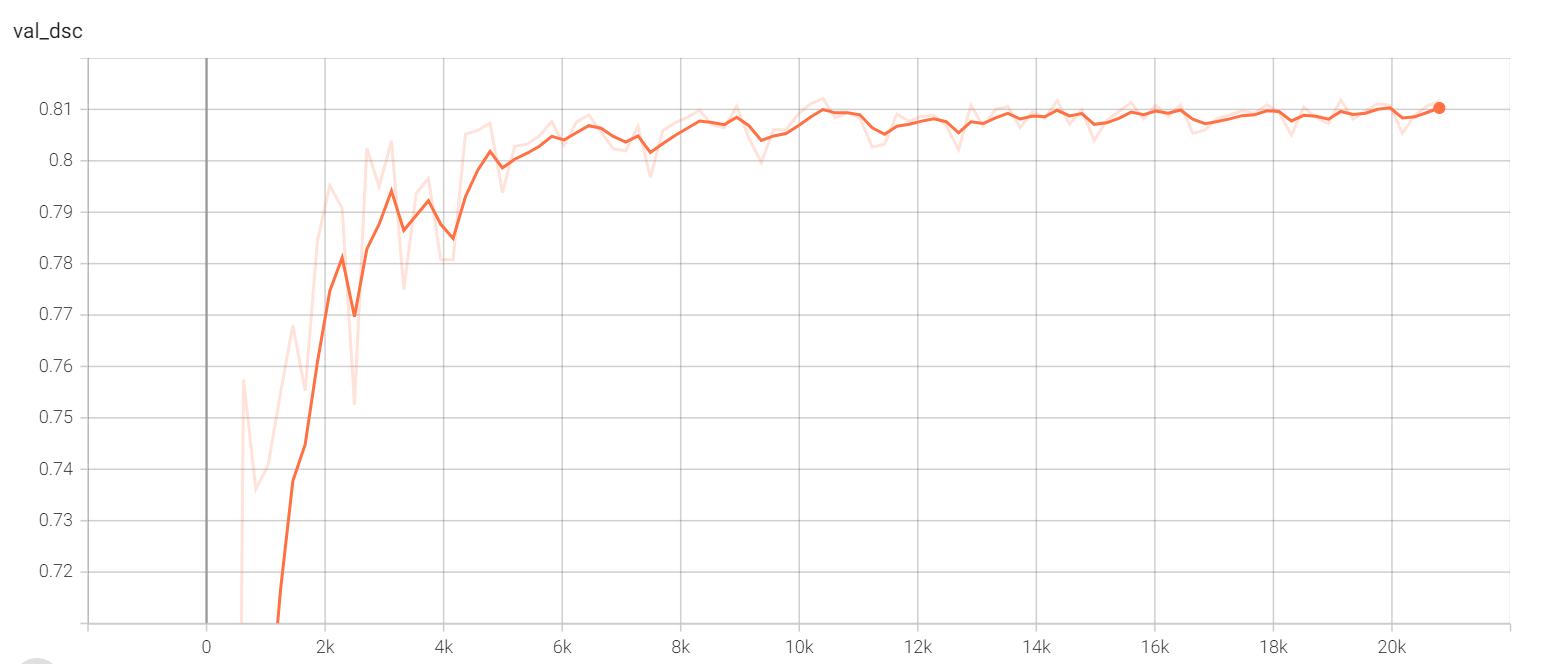

---

### 4.2 U-Net with Nestrove SGD Optimizer and BCE Loss
Configuration: `Batch Size: 20, Max Epoch: 70, Learning Rate: 0.001, Momentum: 0.9, Weight Decay: 1e-4, aug scale: 0.05, aug angle: 15`  

Time Elapse(Training): 2h44m -- 2.34min/epoch converge around 2h9m   
Prediction image:  
Logs: ./logs_bce_sgd  

Best Validation Mean DSC: 0.798099

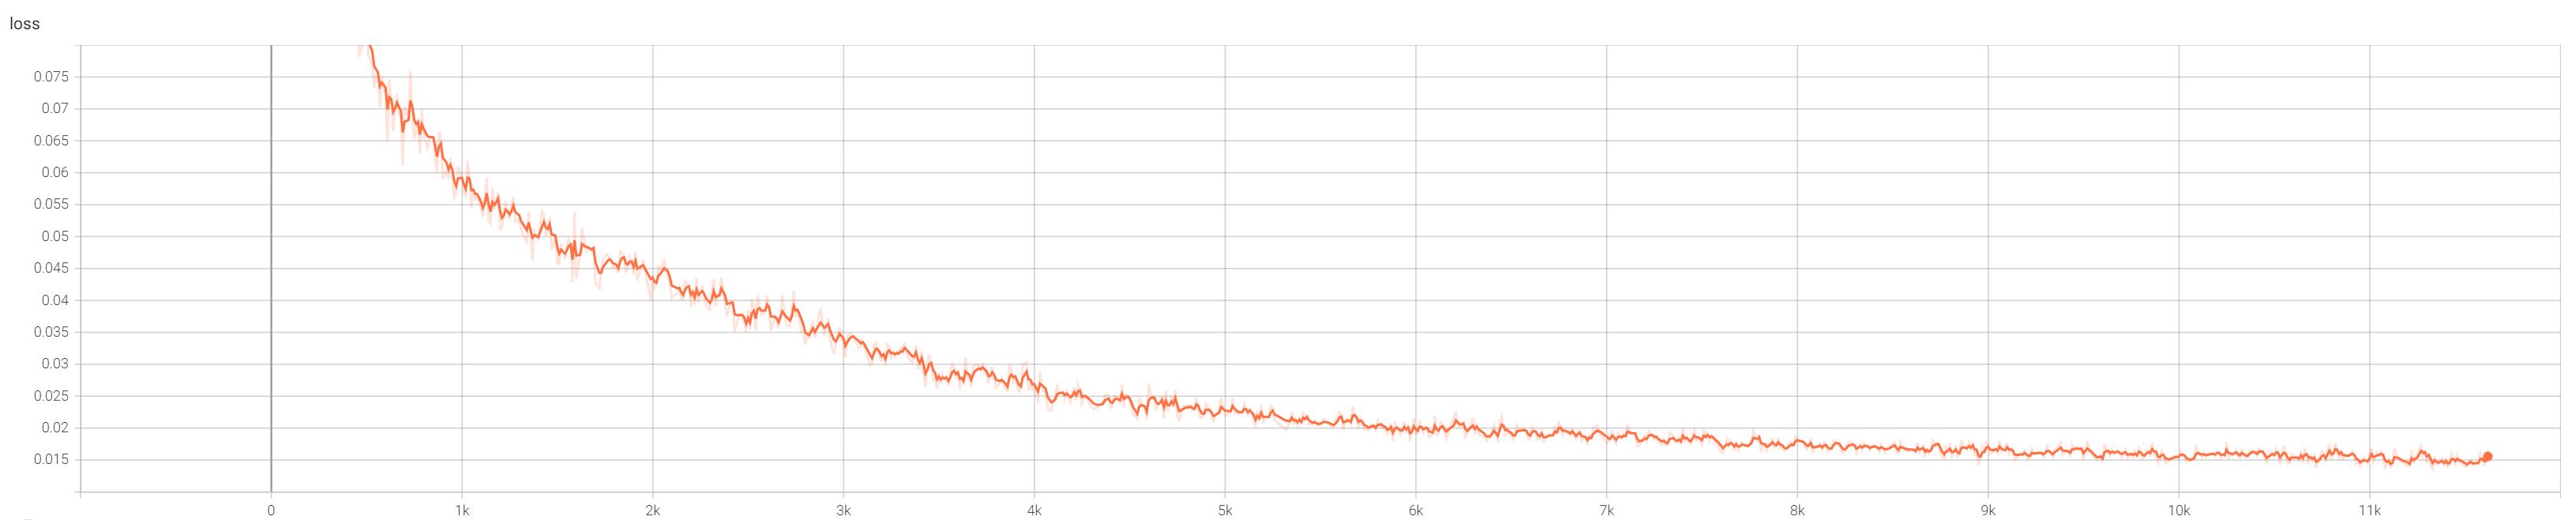
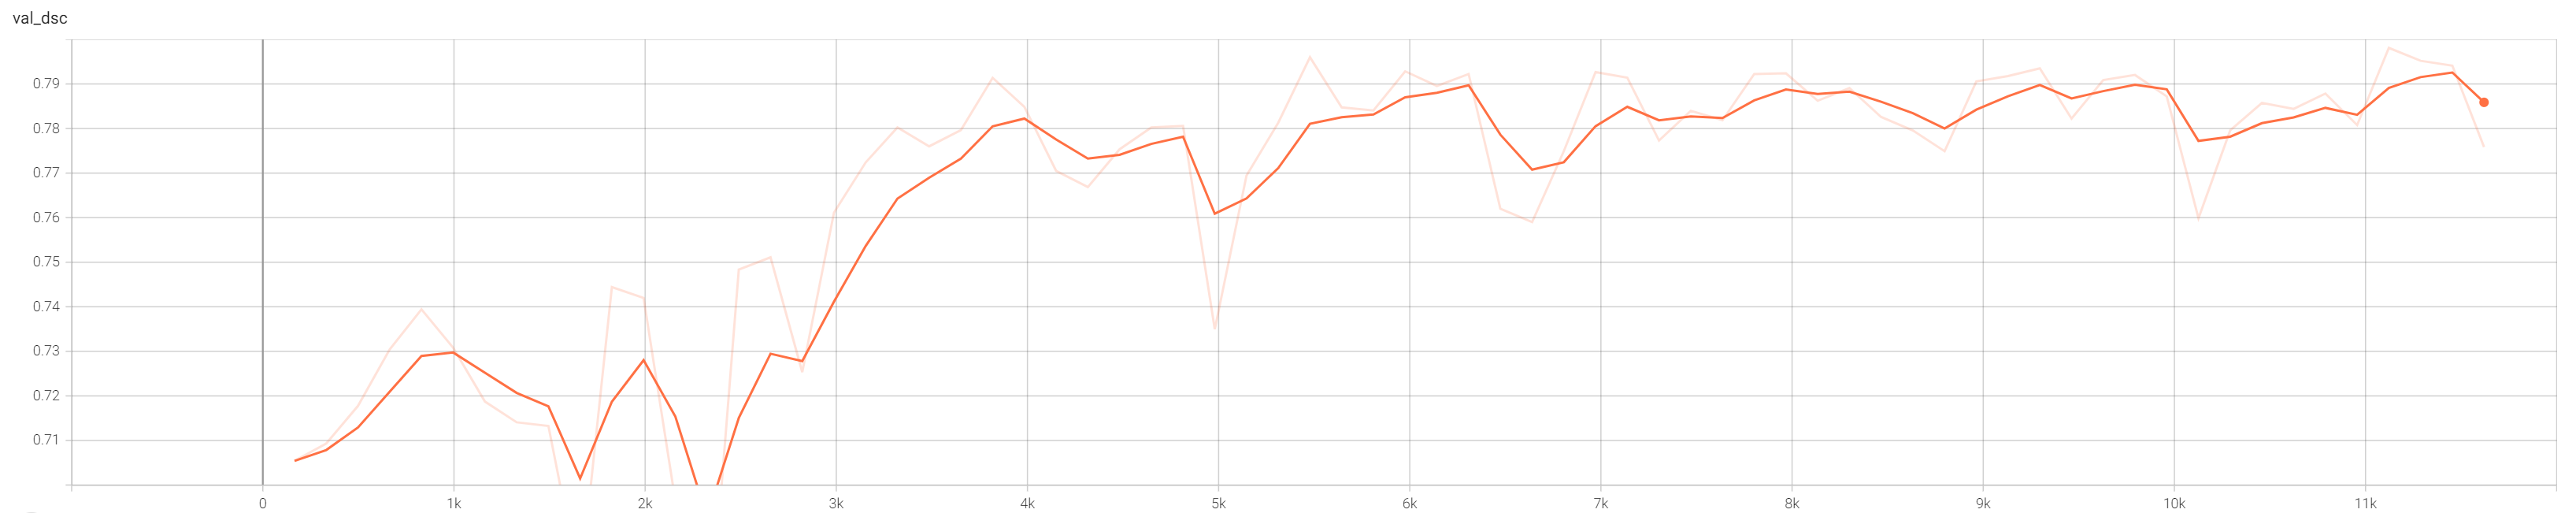

---

### 4.3 U-Net with Nestrove SGD Optimizer and Log-Cosh Dice Loss
Configuration: `Batch Size: 20, Max Epoch: 60, Learning Rate: 0.001, Momentum: 0.9, Weight Decay: 1e-4, aug scale: 0.05, aug angle: 15`  

Time Elapse(Training): 2h13m -- 2.21min/epoch converge around 1h45m   
Prediction image: ./predictions_lcdice_sgd    
Logs: ./logs_lcdice_sgd  

Best Validation Mean DSC: 0.794323

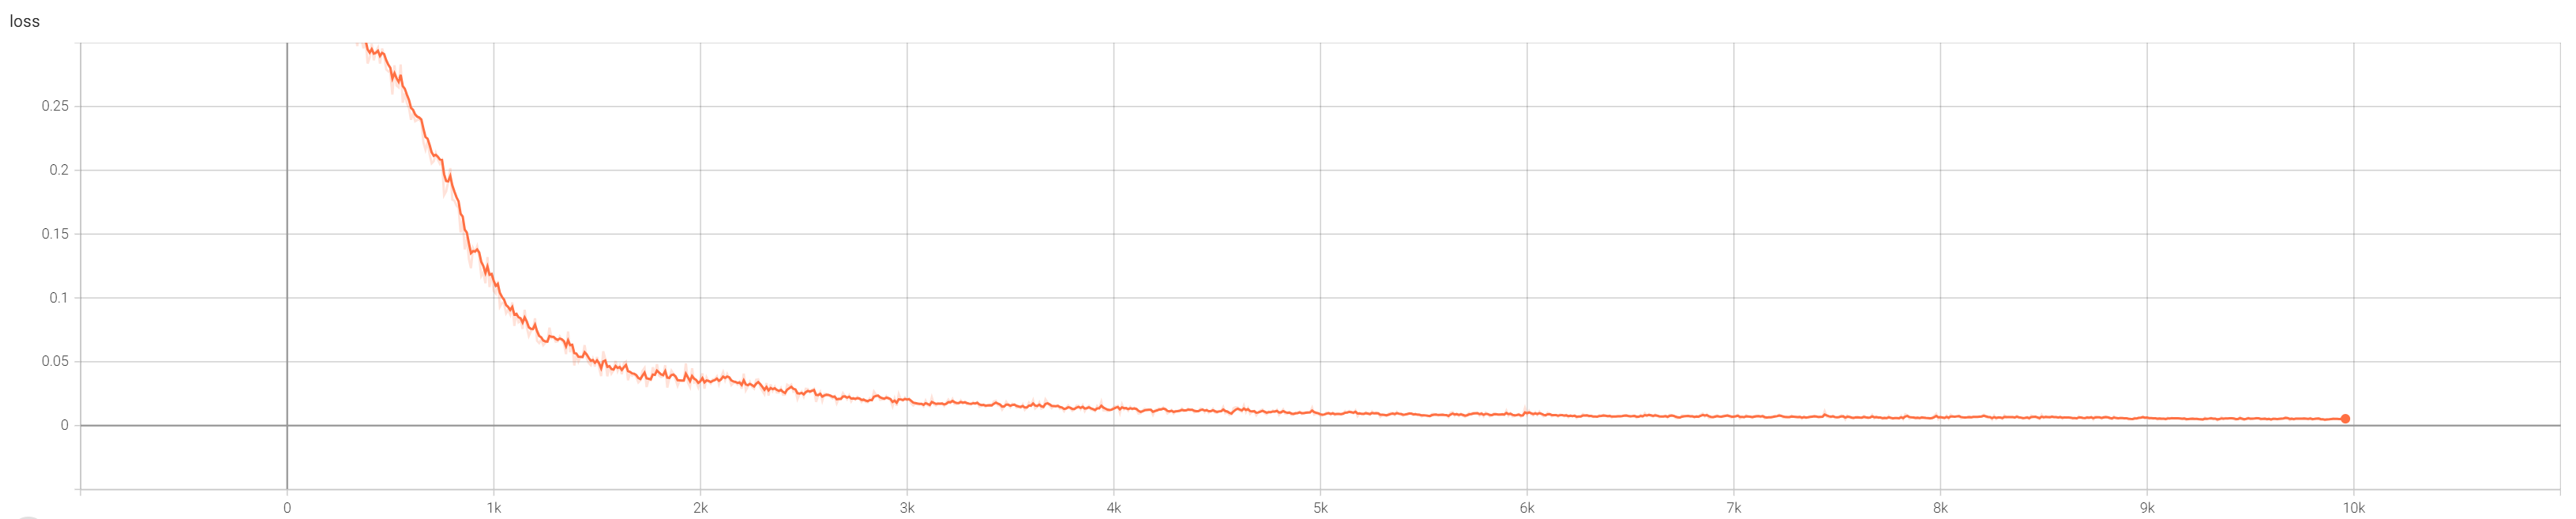
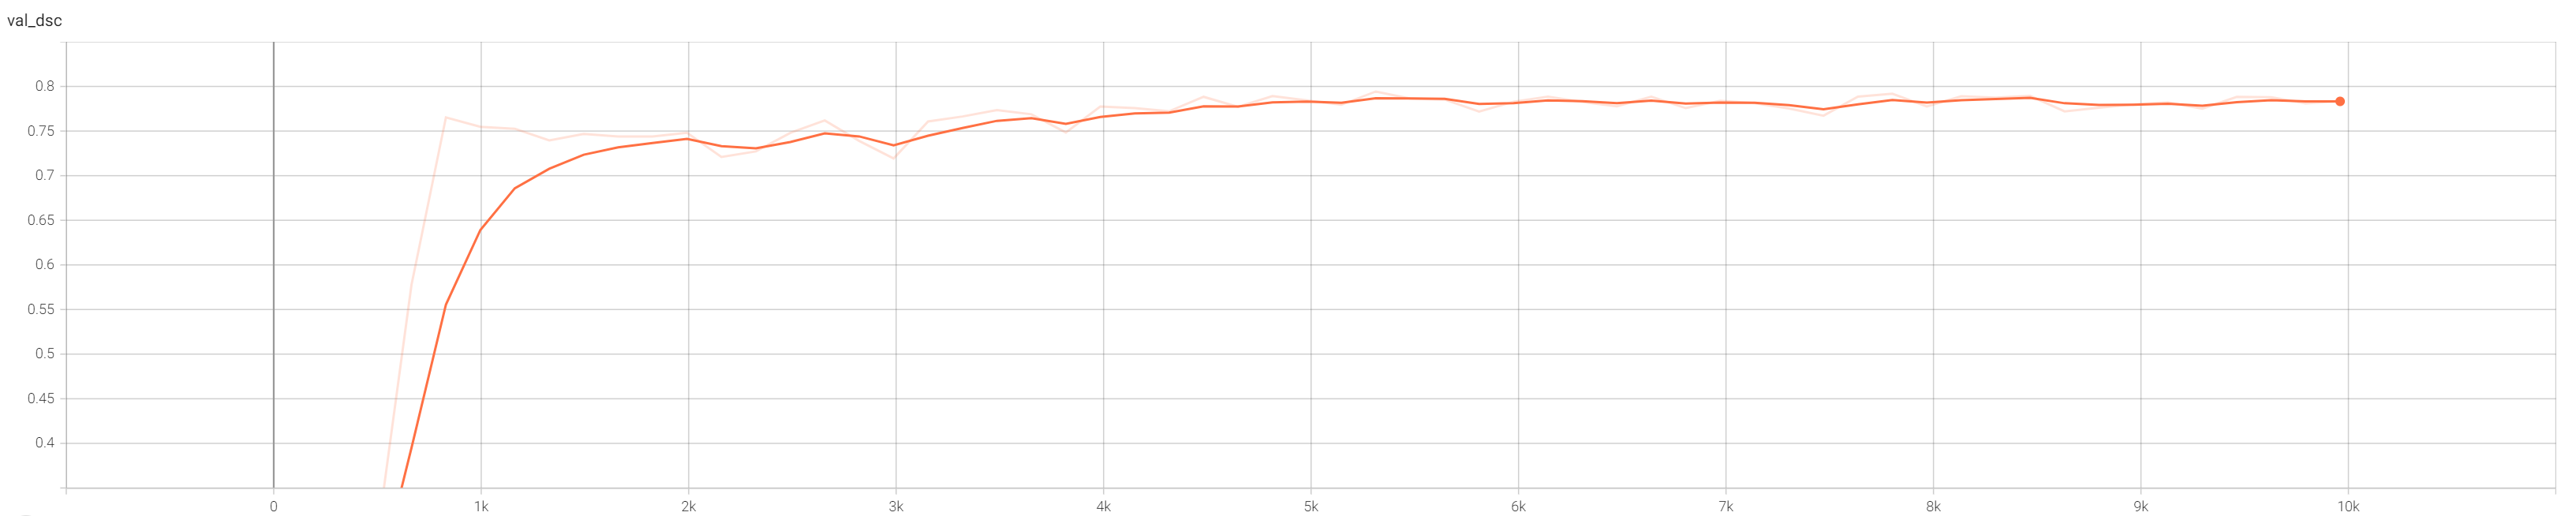


---

### 4.4 U-Net with Nestrove SGD Optimizer and Shape-Aware Loss
Configuration: `Batch Size: 20, Max Epoch: 60, Learning Rate: 0.001, Momentum: 0.9, Weight Decay: 1e-4, aug scale: 0.05, aug angle: 15`  

Time Elapse(Training): 2h1m -- 2.01min/epoch converge around 1h53m   
Prediction image: ./predictions_sa_sgd    
Logs: ./logs_sa_sgd  

Best Validation Mean DSC: 0.793439
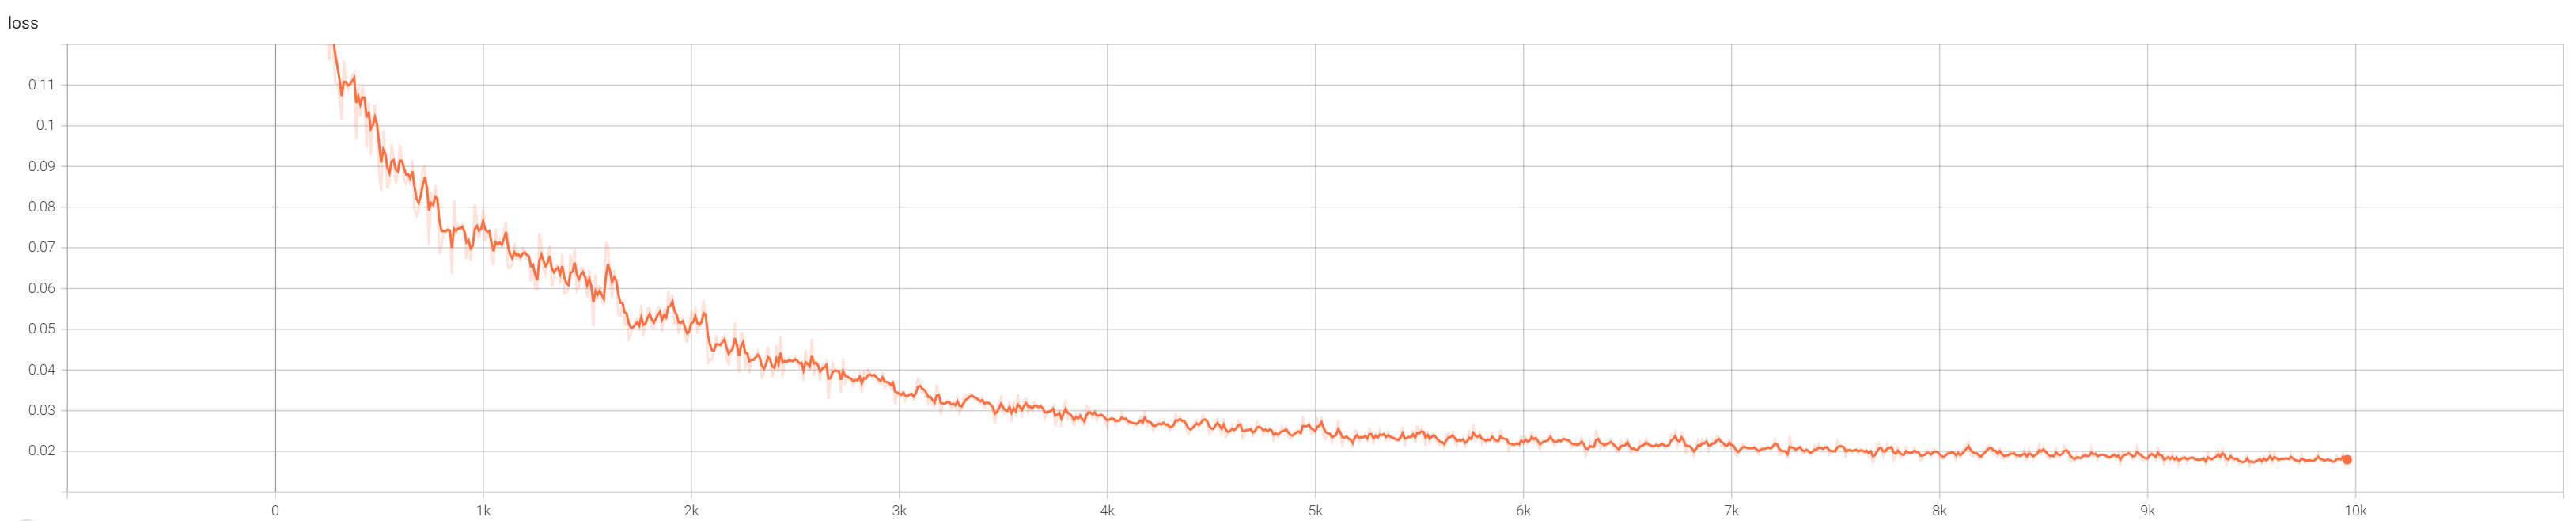
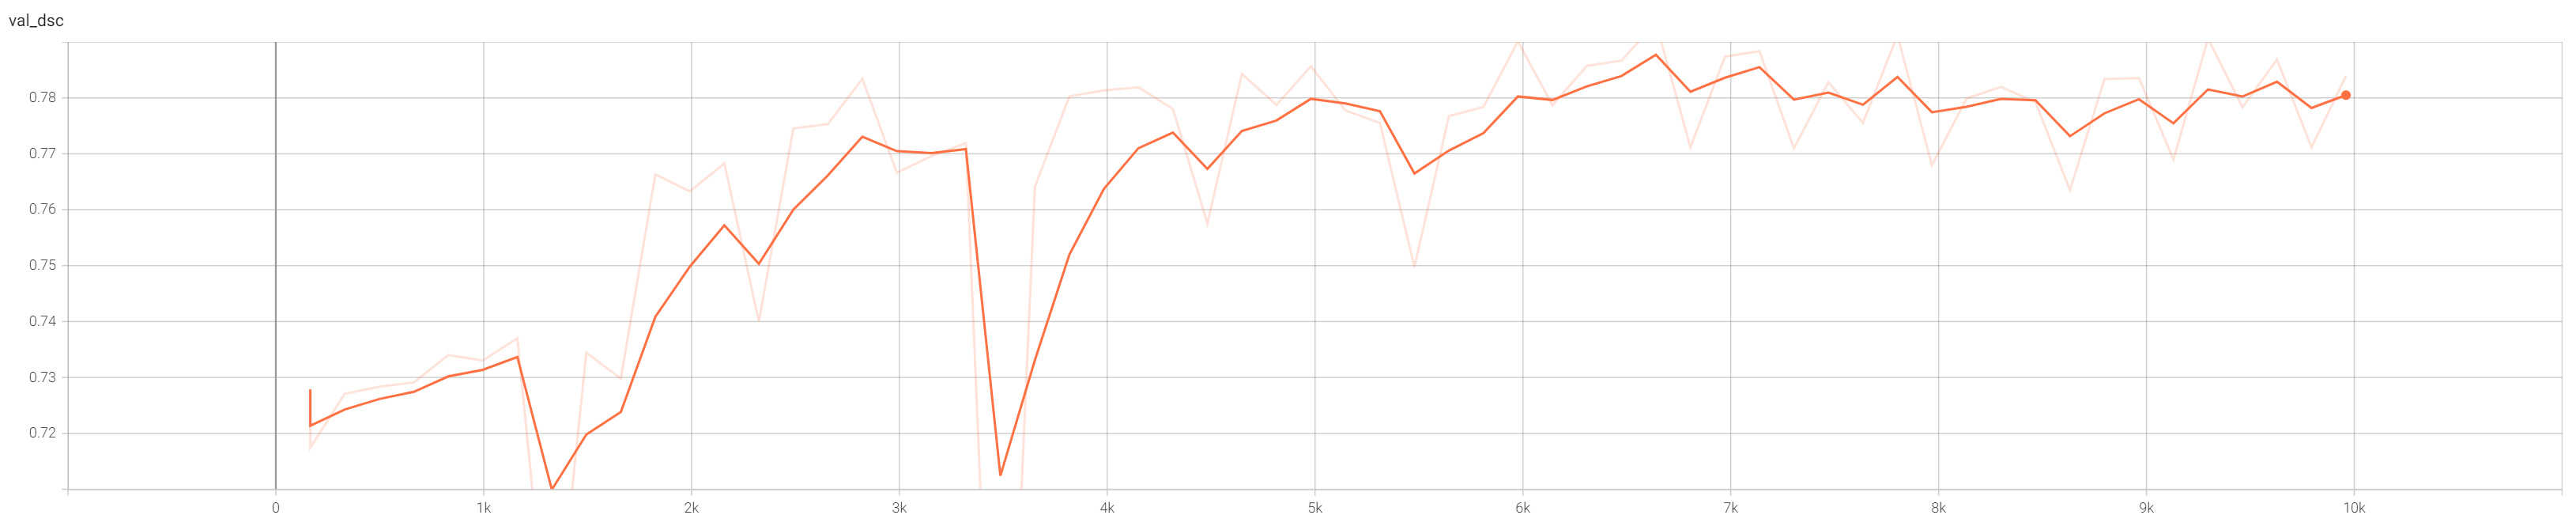

---

### Compare and Contrast
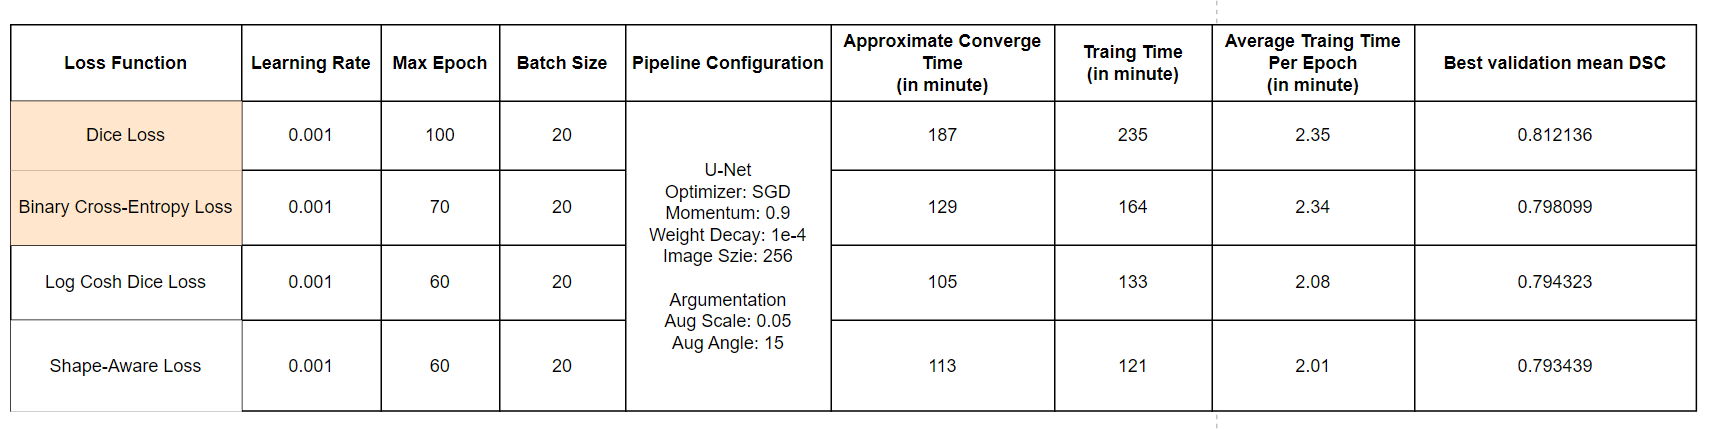


### Inference Dice Coefficient
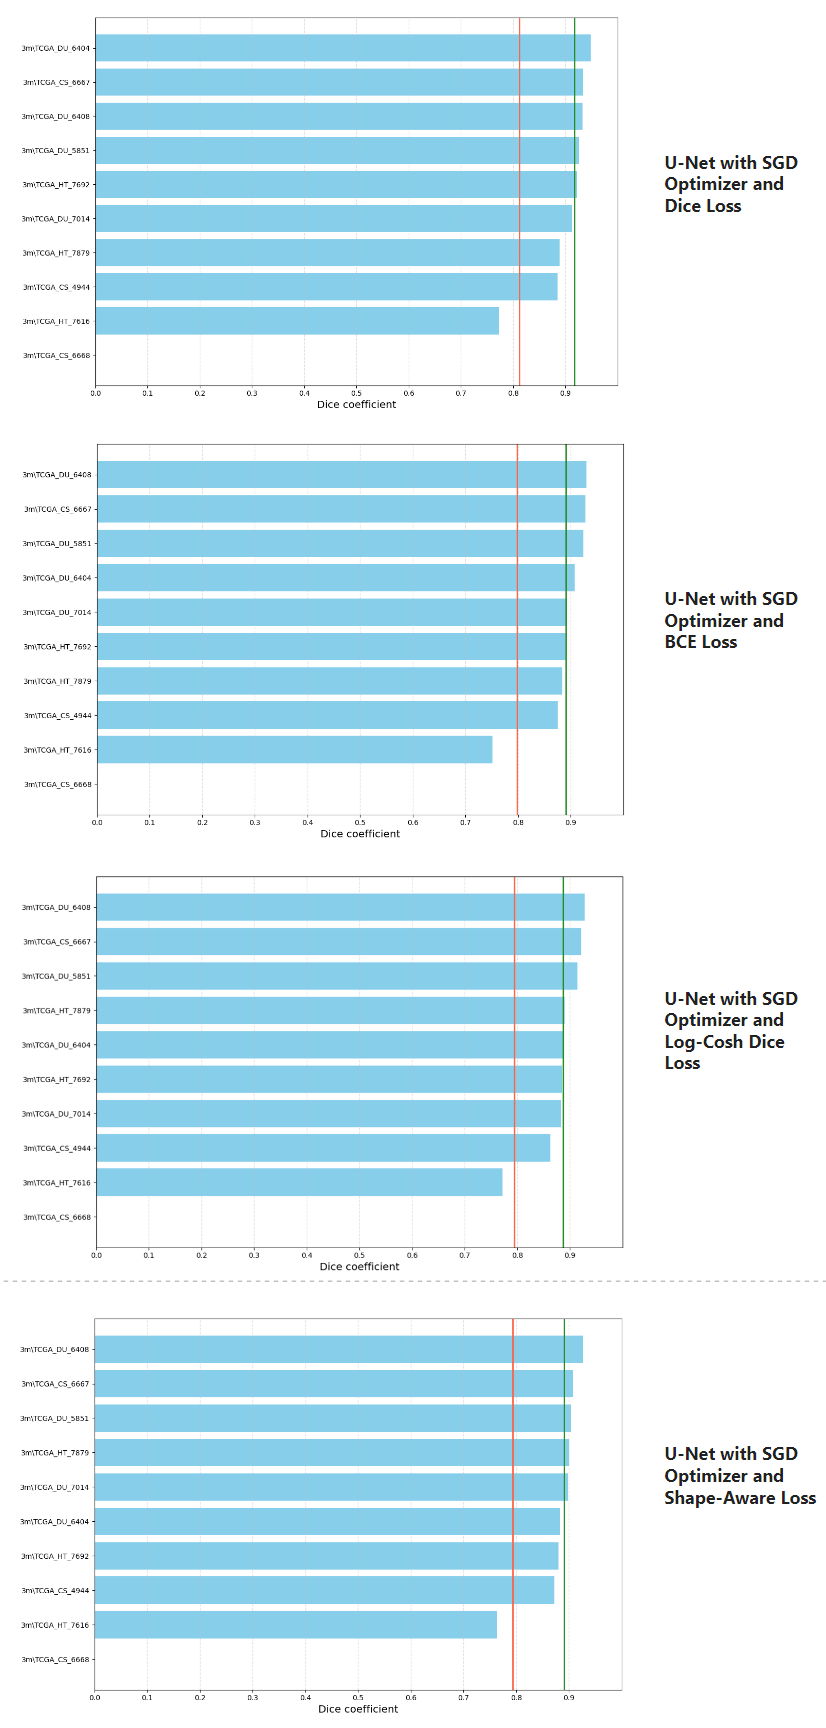

### Segmentation Examples
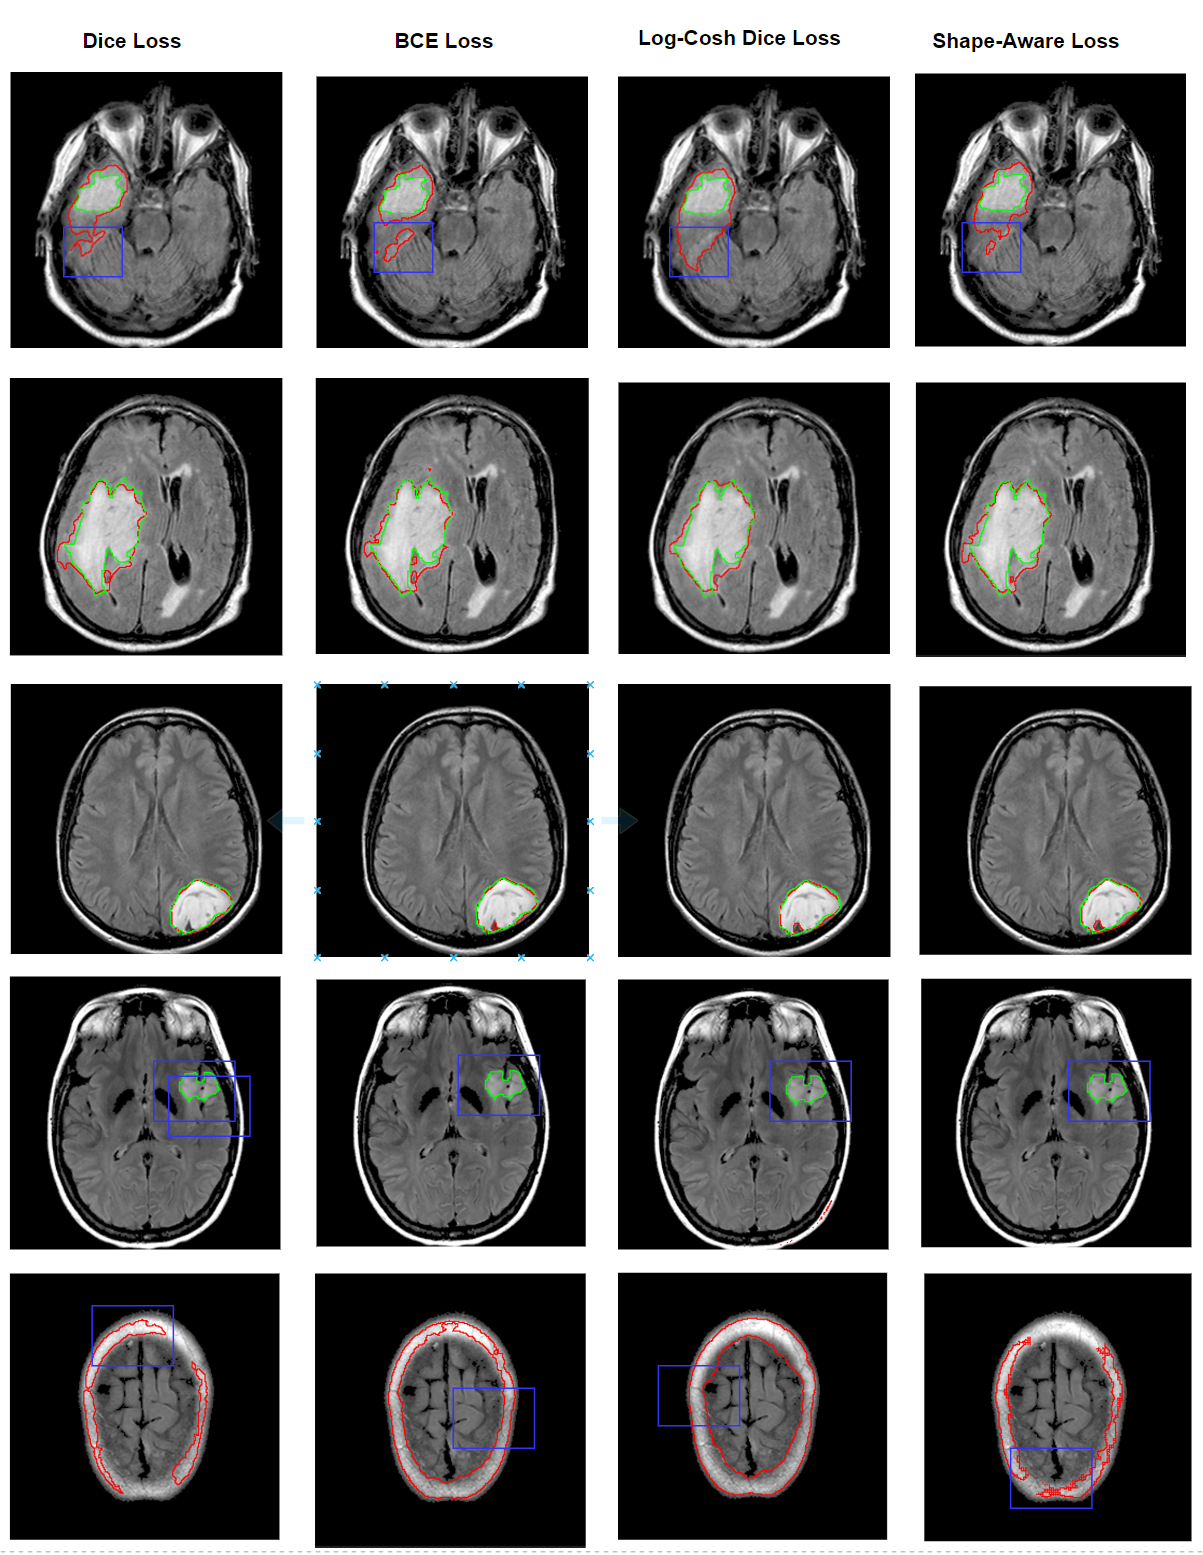

---

### Analysis
1. Same as the U-Net models with Adam optimizer, Dice loss has provided the best segmentation results. The high DSC scores for Dice loss could 
also benefit from the iteration amount(greatest max epoch value among the experiments we run). 
2. Judging from the validation loss curves and validation DSC curves, not much overfitting happens during the training process.
3. Learning rate for U-Net with SGD optimizer is much larger than with Adam optimizer(SGD: 0.001, Adam: 0.0001). SGD generally converges slower than Ad m,
therefore without increasing the learning rate, it is hard for the network to converge within reasonable amount of time.
4. BCE loss has the second best DSC scores when the optimizer is set to SGD. However, based on analysis in the previous section(U-Net with Adam) BCE 
by theory should not have such good performances especially when our data is quite unbalanced. This could be because the hyperparameter settin s for
our tests with SGD optimizer are not reasonable enough.
5. Most of the U-Net models with SGD optimizer only converge after an hour of training, whilst the Adam optimizer has a much faster convergence speed.
6. Adam optimizer has better segmentation results(arounf 10% higher on DSC scores) than SGD optimizer. We could also get a glimpse of this thr ngh the 
Dice Coefficient diagram for inference. Unlike Adam optimizer, with which the mean and median DSC scores for different volumes are close, hese two 
statistic measure scores have comparatively large gaps inbetween with SGD optimizers. This suggests that there are some outlying obsr vations or
predictions happening with SGD optimizer. Detection for TCGA_CS_6688 and TCGA_HT_7616 are evidently much worse than the detection of other volumes.
7. For large or more-regular shape detection, we can see from the segmentation examples here, networks with SGD still have a promi ing resu . However, \
it can also be noticed that many misclassification(not detecting out the lecian or false detecting normal areas as tui ors) happens.
It seems that when the optimizer is set to SGD, the network tends to classify pixels more by the color/grayscale/single-channel contrast.  is results in 
misbehaviour when part of the image is too bright or too dark. The detected shape finds it hard to spot the correct area of a claso or difficult to
maintain shape details(edges). Overall, Adam seems to behave better than SGD in our case.

## 5. Conclusion for U-Net Network Architecture

### 5.1 Optimizers
Optimizers have a huge impact over the performance of a model. We say an optimizer is good if it is fast and efficient, and can generalize well(less overfitting). In our experiment, we discuss the debate on whether Adam or SGD is better under the given task with our dataset. It is generally difficult to select or design an optimizer that provides fast convergence speed and learning results. One interesting and dominant argument about optimizers is that SGD better generalizes than Ada]. However, it does not appear to be the case among the experiments we run. One potential explanation is the hyperparameter settings. Recent papers also argue that Adam could be better with proper hyperparameters  
.
From Secti 3 6 an4 7, we noticed that U-Net with Adam has higher DSC scores, regardless which loss function is used. Models with Adam optimizer also converge much faster than with S.  

### 5.2 Loss Functionsions
A loss function is a mathematical equation that a deep learning architecture tries to minimize or opte[17]. The choice of loss functions depend heavily on the nature of tha dataset and the goal of the t  
ask. 
We compare Dice loss, BCE loss, Log-Cosh Dice loss and Shape-Aware loss in this report. With both optimizers, Dice loss and Shape-Aware loss have provided the best segmentation results with the highest DSC scores. As analyzed previously, with unbalanced data(tumor MRI etc.), BCE loss usually has weak performa  
nces. 
For further investigation, we should test Weighted BCE and IoU loss since these two are also popular loss function choices for semantic segmentation.


## 6. Entend: U-Net++(Nested U-Net) 

For extended experiments, we also try to implement Nested U-Net and TransU-Net architecture. Due to the limited time, we mainly focus on testing Nested U-Net.  

UNet++ uses the Dense block ideas from DenseNet to improve U-Net. It mainly has below differences compared to U-Ne]:1. 
Having convolution layers on skip pathways, which bridges the semantic gap between encoder and decoder feature maps2. .
Having dense skip connections on skip pathways, which improves gradient flo3. w.
Having deep supervision, which enables model pruning and improves or in the worst case achieves comparable performance to using only one  layera

Our experiment uses fast mode rather than deep supervision mode, due to the limited time budget. Below are diagrams for some of the experiments we run.
With the same loss function, there is improvement in U-Net++ learning results compared to U-Net, but not too much(about 0.2% to 0.3%). With more parameter tuning, we can assume that the segmentation can be further improved, however, not statistically significant  

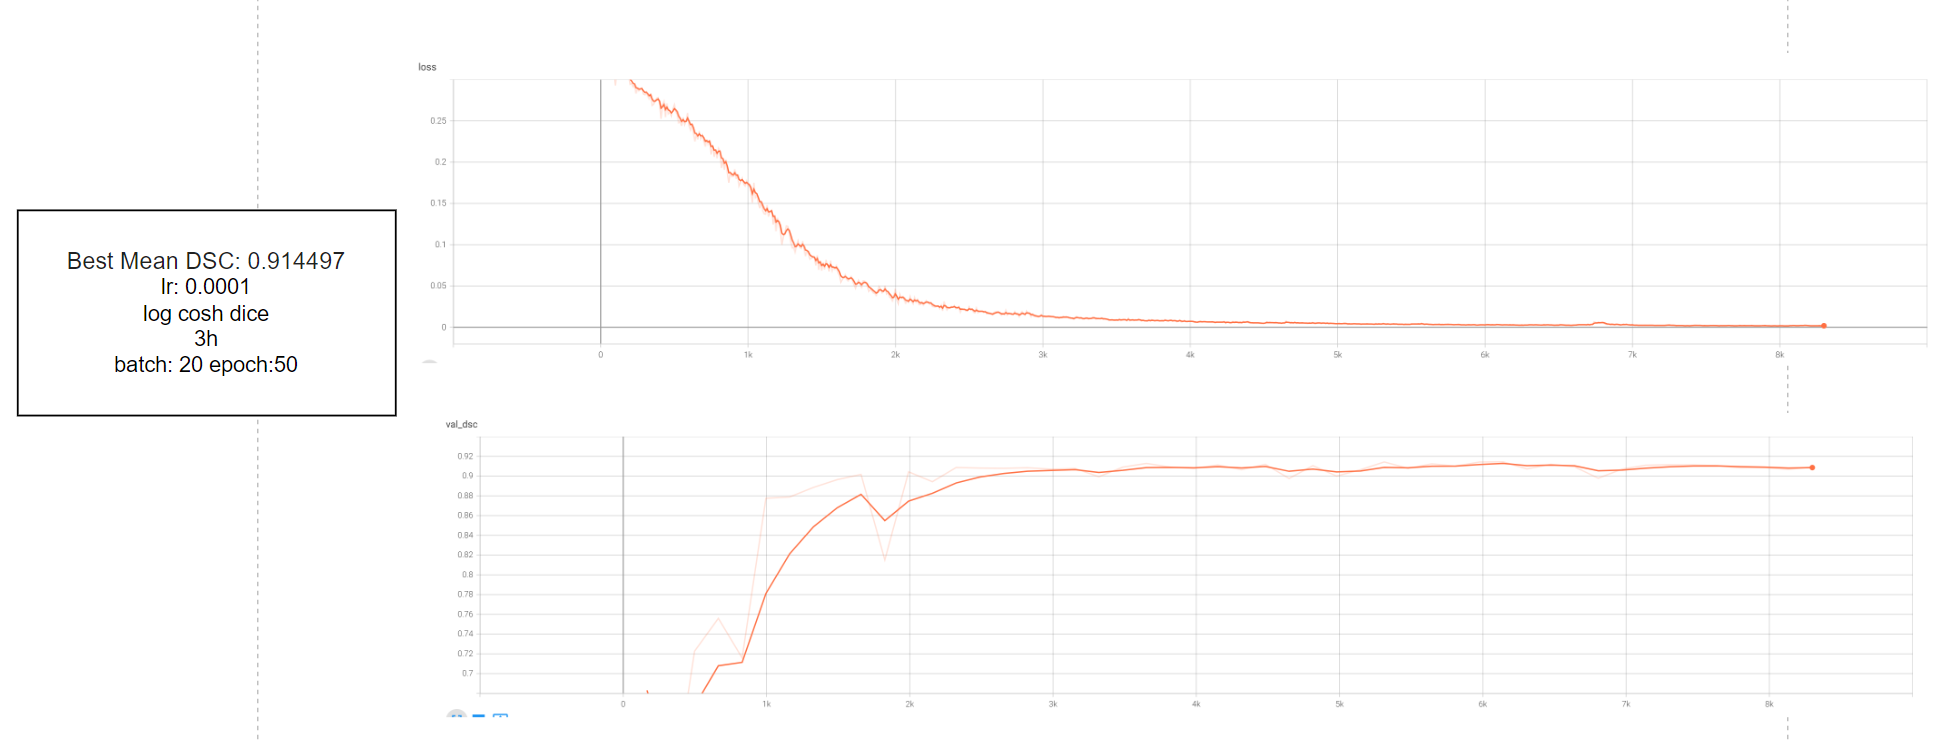
.
In conclusion, the performance of a network architecture can be affected by hyperparameter settings and the dataset. Besides U-Net and Nested U-Net, there are other many U-Net structures and networks that aim at semantic segmentation, and some may have good training results and some may not, depending on the data and the task itself.
18].


## Summary

In our experiments, we compared some common-used loss functions and optimizers and how they affect the U-Net behaviors under our task. Dice similarity coefficient is used to statistically analyze the learning results. The highest DSC score 0.9155 with U-Net structure is with Dice loss and Adam optimizer.   

With U-Net architecture, Dice loss and Log-Cosh Dice loss have proved their advantages at region detection and boundary detection. Throughout the experiments, Adam optimizer also provided faster convergence speed and better segmentation results than SGD optimizer. However, a conclusion of which optimizer is better still could not be made since we only run limited experiments, and the behaviors of an optimizer could be hugely affected by the hyperparameter settings. For further investigation, we should do more experiments, perhaps with GridSearch and so on to find the best hyperparameter settings for each optimizer and then compare the segmentation results accordingly. It would also be interesting if we could introduce ways to quantify and compare the stability of a model with different optimizers  
.
With the same loss function, there is improvement in U-Net++ learning results compared to U-Net, but not too much(about 0.2% to 0.3%). With more parameter tuning, we can assume that the segmentation can be further improved, however, not statistically significant.
In conclusion, the performance of a network architecture can be affected by hyperparameter settings and the dataset. Besides U-Net and Nested U-Net, there are other many U-Net structures and networks that aim at semantic segmentation, and some may have good training results and some may not, depending on the data and the task itse  
lf.
Both the U-Net and U-Net++ architectures have comparatively good performances on segmentation and edge maintenance, but still fail to detect accurate shapes especially when the target area is small or when the shape has edges with many turns. To improve this, we could test TransU-Net, or try to combine with some adaptive methods to detect these poor-behaving areas and make them tokens with higher import semantic meaning.g.
f.
